<a href="https://colab.research.google.com/github/yelinhu/wallstreetNets/blob/main/Cis545Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **wallstreetNets: Training Models on r/wsb Posts**
Big Data Analytics (CIS 545) Final Project
##### Group Members: Weilin Hu, Justin Dong, and Yelin Hu


# **Introduction and Background**

Recent events in “meme stocks” (meme stonks as some call it) broke
conventional wisdom. For example, GameStop, an American high street shop
that sells games, consoles, and other electronics, was the center of attention
in the beginning of 2021; however, before then, it was short of new and
exciting - in fact, it wasn’t doing well because of the pandemic. It wasn’t until members in Reddit’s forum called wallstreetbets, a forum to discuss stocks
and shares, started swapping tips and bought shares in GameStop as well as
other stocks due to its high short sales from hedge funds. This created a very
interesting phenomenon and something many analysts and researchers
would say is “irrational” behavior. Because of this, our group decided to make
sense of it all.

**Warning: our analysis and data exploration may contain explicit language that might be offensive to some readers. Enjoy.**


## Libraries and Setup

In [1]:
!pip install praw
!pip install yahoofinance
!pip install pandasql
# !pip install --upgrade plotly

     |████████████████████████████████| 167 kB 2.8 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26781 sha256=851fe3a1ef07dcc42bdb33bbe1947ddff483db4cf0fa9afc8ec9515589e2d471
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [ ]:
import praw, gdown, pandas as pd, os, datetime as dt, numpy as np, re
import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
plt.style.use('seaborn')
sns.set_style('darkgrid')
from google.colab import drive
from yahoofinance import HistoricalPrices
from pandasql import sqldf
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

# create folder to write data to
CIS545_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS545_2021')
HOMEWORK_FOLDER=os.path.join(CIS545_FOLDER, 'Project')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/gdrive


# **Data Collection and Cleaning**

## I. Collecting the *wallstreetbets* Reddit post data

Let us load in the primary dataset from Kaggle: 

https://www.kaggle.com/gpreda/reddit-wallstreetsbets-posts

In [ ]:
# initialize Reddit API client
reddit = praw.Reddit(
    client_id="5Jo79-TH1yp1Ww",
    client_secret="oAm4gGRWOvRlifGWnMJjsDLTeuq3ag",
    user_agent="python:cis545:v1.0 (by /u/RedditAPI545)",
)

# make a file publicly shared, id is in the link
# Dataset updated to Apr 21, 2021
url = 'https://drive.google.com/uc?id=15FV5rA_jnaEnD6HKaHUYiU5XX-OW5p7R'
output = 'reddit_wsb.csv.zip'
gdown.download(url, output, quiet=False)

!unzip -o '/content/reddit_wsb.csv.zip'

Downloading...
From: https://drive.google.com/uc?id=15FV5rA_jnaEnD6HKaHUYiU5XX-OW5p7R
To: /content/reddit_wsb.csv.zip
12.9MB [00:00, 45.2MB/s]


Archive:  /content/reddit_wsb.csv.zip
  inflating: reddit_wsb.csv          


We will collect username data using the Reddit API and clean our dataset by removing any posts that no longer exist.

This takes about 13 minutes to run for the first time.

If you want to scrape the user data again, uncomment the following cell.

In [ ]:
# # removes existing saved csv from Drive
#users_path = os.path.join(HOMEWORK_FOLDER, os.path.join(HOMEWORK_FOLDER, 'reddit_wsb_users.csv'))
#os.remove(users_path)

In [ ]:
posts = pd.read_csv('/content/reddit_wsb.csv')
# path of csv with 'user' column (might not exist yet, might be outdated)
users_path = os.path.join(HOMEWORK_FOLDER, os.path.join(HOMEWORK_FOLDER, 'reddit_wsb_users.csv'))
if not os.path.isfile(users_path):
  # IDs for API have format t3_[id]
  t3_ids = []
  users = []
  percent_upvotes = []
  is_self_list = []
  link_flair_text_list = []
  num_comments_list = []
  score_list = []
  selftext_list = []
  title_list = []
  url_list = []

  # store the valid ids returned by API
  valid_ids = []

  # convert ids to t3_ids
  for id in list(posts['id']):
    t3_ids.append("t3_" + str(id))

  count = 0
  for post in reddit.info(fullnames=t3_ids):
    valid_ids.append(post.id)
    author = post.author
    if author is not None:
      name = author.name
    else:
      name = None
    upvote_ratio = post.upvote_ratio
    this_is_self = post.is_self
    this_flair_text = post.link_flair_text
    this_num_comments = post.num_comments
    this_score = post.score
    this_selftext = post.selftext
    this_title = post.title
    this_url = post.url
    
    # show progress
    count += 1
    if count % 100 == 0:
      print("Progress: " + str(count) + "/" + str(len(t3_ids)))
    users.append(name)
    percent_upvotes.append(upvote_ratio)
    is_self_list.append(this_is_self)
    link_flair_text_list.append(this_flair_text)
    num_comments_list.append(this_num_comments)
    score_list.append(this_score)
    selftext_list.append(this_selftext)
    title_list.append(this_title)
    url_list.append(this_url)

  # clean posts
  invalid_ids = []
  for t3_id in t3_ids:
    if t3_id[3:] not in valid_ids:
      invalid_ids.append(t3_id[3:])
  for invalid_id in invalid_ids:
    posts = posts.drop(posts[posts['id'] == invalid_id].index[0])

  posts['user'] = users
  posts['upvote_ratio'] = percent_upvotes
  posts['is_self'] = is_self_list
  posts['link_flair_text'] = link_flair_text_list
  posts['num_comments'] = num_comments_list
  posts['score'] = score_list
  posts['selftext'] = selftext_list
  posts['title'] = title_list
  posts['url'] = url_list

else:
  # file already exists
  posts = pd.read_csv(users_path)

Save posts with username data to Drive, so we don't have to scrape data again.

In [ ]:
posts.to_csv(users_path, index=False)

Here we clean out any unnecessary columns. 

We took out `created` (Creation timestamp in seconds) because there was a similar column `timestamp` that captures each post's creation time.

We also took out `comms_num` since there is an updated column `num_comments` with the number of comments directly extracted from the Reddit API.

In [ ]:
posts_clean = posts[['title', 'score', 'id', 'url', 'num_comments', 'body', 'timestamp', 'user', 'upvote_ratio', 'is_self', 'link_flair_text', 'selftext']]


We convert the timestamp column from dtype object to datetime64[ns].

The time zone is UTC, which is the same as the date from Yahoo Finance.

We create a column called date without the time, so that we can match posts to closing prices.

In [ ]:
posts_clean['timestamp'] = pd.to_datetime(posts_clean['timestamp'], infer_datetime_format=True)
posts_clean['date'] = pd.to_datetime(posts_clean['timestamp'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m-%d')))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We create another dataframe without any null usernames, so that these users don't get combined as a user named NaN.

In [ ]:
posts_drop_null_users = posts_clean[posts_clean['user'].notnull()]

## II. Collecting stock data for $GME

We create a dataframe for GME price and volume data from Yahoo Finance.

In [ ]:
start_date = posts['timestamp'].sort_values().iloc[0]
end_date = posts['timestamp'].sort_values().iloc[len(posts)-1]
print('start_date', start_date)
print('end_date', end_date)

# obtain stock prices of ticker GME ranging from start to end date into .csv file
HistoricalPrices('GME', start_date=start_date, end_date=end_date, date_format_string='%Y-%m-%d %H:%M:%S').to_csv('gme.csv')
gme_df = pd.read_csv('gme.csv')
gme_df = gme_df.drop(['Adj Close'], axis=1)
gme_df.columns = gme_df.columns.str.lower()

start_date 2020-09-29 03:46:56
end_date 2021-04-21 20:25:42


We add a column for previous close and next close by iterating through the gme_df. This will be useful to see if text sentiment of posts is related to price movements and for predicting the next day's change.

We also add a column for percent change as `( close - prev_close ) / prev_close`.

In [ ]:
prev_close = []
prev = None
next_close = []
next = None
for row in gme_df.iterrows():
  prev_close.append(prev)
  prev = row[1]['close']
for row in gme_df[::-1].iterrows():
  next_close.insert(0, next)
  next = row[1]['close']

# add prev_close and next_close columns
gme_df['prev_close'] = prev_close
gme_df['next_close'] = next_close

gme_df = sqldf('select *, (close-prev_close) / prev_close as percent_change from gme_df')

Convert dates in gme_df to unix datetime so we can join the tables.

In [ ]:
gme_df['date'] = pd.to_datetime(gme_df['date'], infer_datetime_format=True)

## III. Joining *wallstreetbets* posts data with stock information
Gamestop? Seems More Like Games Have Just Started

We match the dates of posts with stock data using a left join.

Note that many of the rows don't have stock data because the posts were made over the weekend or on a holiday.

Column Descriptions:
* `title`: The title of the post
* `score`: Net upvotes of the post
* `id`: Unique identifier of the post
* `url`: URL of image if one exists; otherwise, URL of post
* `num_comments`: The number of comments on this post
* `body`: Body text of post
* `user`: Author of post
* `upvote_ratio`: # upvotes / upvotes + downvotes
* `link_flair_text`: Category/topic of post
* `is_self`: 1 if post is text only, 0 o.w.
* `selftext`: Updated body text of post
* `date`: Date posted
* `open`: Stock price of \$GME at time market opened
* `high`: Highest stock price of \$GME on that day
* `low`: Lowest stock price of \$GME on that day
* `close`: Stock price of \$GME at time market closed
* `percent_change`: (close-prev_close)/prev_close
* `prev_close`: Closing stock price of \$GME on the day before
* `next_close`: Closing stock price of \$GME on the day after
* `volume`: Volume of \$GME trades that day

In [ ]:
posts_stock_data = sqldf('select title, score, id, url, num_comments, body, user, upvote_ratio, link_flair_text, is_self, selftext, posts_clean.date, open, high, low, close, percent_change, prev_close, next_close, volume from posts_clean left join gme_df on posts_clean.date = gme_df.date')
posts_stock_data['date'] = pd.to_datetime(posts_stock_data['date'])
posts_stock_data.sample(5)

,title,score,id,url,num_comments,body,user,upvote_ratio,link_flair_text,is_self,selftext,date,open,high,low,close,percent_change,prev_close,next_close,volume
32663,RDFN YOLO update - added another $100k to my Y...,98,lh035y,https://www.reddit.com/gallery/lh035y,59,None,glamoutfit,0.85,YOLO,0,None,2021-02-11,50.009998,55.320000,48.220001,51.099998,-0.001953,51.200001,52.400002,13056700.0
25,Really? I can’t even buy GME or AMC for now? 😤,705,l6tt3i,https://i.redd.it/mvfo6m14z1e61.jpg,415,None,None,0.97,Discussion,0,[deleted],2021-01-28,265.000000,483.000000,112.250000,193.600006,-0.442894,347.510010,325.000000,58815800.0
3985,Congressional Hearing incoming?,8,l6zhiq,https://twitter.com/RashidaTlaib/status/135480...,0,None,seedykonto,0.91,Discussion,0,None,2021-01-29,379.709991,413.980011,250.000000,325.000000,0.678719,193.600006,225.000000,50566100.0
37203,'Roaring Kitty' no longer has financial broker...,547,lvlm1e,https://www.reuters.com/article/idUSKCN2AT3OX?...,127,None,nesbas,0.90,News,0,None,2021-03-02,116.930000,133.199997,112.199997,118.180000,-0.018439,120.400002,124.180000,33640400.0
45042,Crunching some numbers on Moderna (MRNA) upcom...,42,ms81qo,https://www.reddit.com/r/wallstreetbets/commen...,47,I have had my eye on Moderna (MRNA) for a whil...,Wolf_of_Wal-mart,0.73,DD,1,I have had my eye on Moderna (MRNA) for a whil...,2021-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **EDA (Exploratory Data Analysis)**

## I. **Users**

What percentage of posts are by users who posted in r/WSB and deleted their accounts?

In [ ]:
posts['user'].isna().sum() / len(posts)

0.17108449649949364

Putting users' total upvotes, post count, and average upvotes together in user_df

In [ ]:
user_df = sqldf('select user, sum(score) as total_upvotes, count(*) as post_count, avg(score) as avg_upvotes'
' from posts_clean where user is not null group by user order by total_upvotes desc')
user_df.head()

,user,total_upvotes,post_count,avg_upvotes
0,OPINION_IS_UNPOPULAR,1705869,230,7416.821739
1,DeepFuckingValue,1591831,10,159183.100000
2,keenfeed,936754,15,62450.266667
3,game_stone,743259,9,82584.333333
4,dhiral1994,546145,58,9416.293103


### 1. Which users post the most often?

In [ ]:
user_df.sort_values('post_count', ascending=False).head(10)

,user,total_upvotes,post_count,avg_upvotes
0,OPINION_IS_UNPOPULAR,1705869,230,7416.821739
67,pdwp90,127427,61,2088.967213
283,AutoModerator,61686,60,1028.100000
4,dhiral1994,546145,58,9416.293103
2666,Jesus_Gains_Christ,2691,32,84.093750
9,indonesian_activist,292684,31,9441.419355
677,Unsquidabls,28427,25,1137.080000
3102,disgruntledbkbum,1836,25,73.440000
6,MIA4real,376868,23,16385.565217
3331,dvdgelman7,1556,22,70.727273


### 2. Which users are the most influential?

Which users had the highest average upvotes per post?

We can consider the top average upvoted users with 5 or more posts to be consistently influential.

In [ ]:
top_influential = sqldf('select user, total_upvotes, post_count, avg_upvotes '
'from user_df where post_count > 4 and avg_upvotes > 1000 order by avg_upvotes desc limit 100')
top_influential.head(100)

,user,total_upvotes,post_count,avg_upvotes
0,DeepFuckingValue,1591831,10,159183.100000
1,game_stone,743259,9,82584.333333
2,keenfeed,936754,15,62450.266667
3,zachp004,253421,5,50684.200000
4,bawse1,264126,7,37732.285714
...,...,...,...,...
95,chayse1984,42882,10,4288.200000
96,Jgslayer01,41632,10,4163.200000
97,Wonderboi1995,20693,5,4138.600000
98,Worried-Counter-958,23525,6,3920.833333


These users consistently get tens of thousands of upvotes on their posts, so it would be interesting to see how they manage to do this.

We recognize some of the most influential users such as DFV, who has been featured in numerous video interviews as well as court hearings this past year. 

On the other hand, there are many users who have only one or two popular posts. What do these users do differently?

In [ ]:
not_influential = sqldf('select user, total_upvotes, post_count, avg_upvotes '
'from user_df where post_count <= 4 and avg_upvotes > 1000 order by avg_upvotes desc limit 500')
not_influential.head(500)

,user,total_upvotes,post_count,avg_upvotes
0,SomeGuyInDeutschland,408751,1,408751.0
1,vrweensy,313869,1,313869.0
2,does-it-mater,221644,1,221644.0
3,mpwrd,210434,1,210434.0
4,84935,209187,1,209187.0
...,...,...,...,...
495,lifeinthefastLAN,73923,3,24641.0
496,helloprof,24639,1,24639.0
497,jppeer123,24569,1,24569.0
498,webacerob,24542,1,24542.0


### 3. What makes a user influential? What do influential users post about?

In this section, we'll analyze the topics that consistently popular users post about, and compare to those that only have a couple of popular posts.

Here are some posts by consistently upvoted users:

In [ ]:
posts_by_influential = posts_clean[posts_clean['user'].isin(top_influential['user'])]
posts_by_influential['influential'] = 'Influential'
posts_by_influential.sample(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,title,score,id,url,num_comments,body,timestamp,user,upvote_ratio,is_self,link_flair_text,selftext,date,influential
16109,"Texas fifth-grader makes $3,200 off GameStop s...",16818,l7ifmk,https://nypost.com/2021/01/28/fifth-grader-mak...,389,NaN,2021-01-29 13:54:05,rspix000,0.98,False,Gain,NaN,2021-01-29,Influential
22487,I don’t feel good Mr. Stonk,142,lb3g3h,https://i.redd.it/vbwpalnp34f61.jpg,32,NaN,2021-02-03 05:00:49,vocchiogrosso,0.71,False,Loss,NaN,2021-02-03,Influential
36840,GME YOLO month-end update — Feb 2021,144908,lt7v4w,https://i.redd.it/20ro9puizvj61.png,7916,NaN,2021-02-27 07:07:18,DeepFuckingValue,0.93,False,YOLO,NaN,2021-02-27,Influential


Here are some posts by users who had a popular post but weren't able to build a reputation in the community:

In [ ]:
posts_by_not_influential = posts_clean[posts_clean['user'].isin(not_influential['user'])]
posts_by_not_influential['influential'] = 'Not Influential'
posts_by_not_influential.sample(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,title,score,id,url,num_comments,body,timestamp,user,upvote_ratio,is_self,link_flair_text,selftext,date,influential
19908,My grandfather told me I would fail and to cal...,24933,l9culr,https://i.redd.it/4w5mwkjncoe61.jpg,1115,NaN,2021-02-01 00:02:26,SwagMoneyKingdom,0.96,False,Gain,NaN,2021-02-01,Not Influential
17254,Why This Weekend Is So Crucial...,43967,l7wmkf,https://www.reddit.com/r/wallstreetbets/commen...,3242,Ok listen up retards... I know it's Friday and...,2021-01-30 02:19:19,HoldUntilYouDie,0.98,True,Discussion,Ok listen up retards... I know it's Friday and...,2021-01-30,Not Influential
35019,Oh my god I'm going to fucking pass out.,64921,lrnc62,https://i.redd.it/ubtvx0gqohj61.jpg,3580,NaN,2021-02-25 06:58:21,jaboyles,0.93,False,Gain,NaN,2021-02-25,Not Influential


We make a boxplot of upvote ratio for influential and non-influential users.

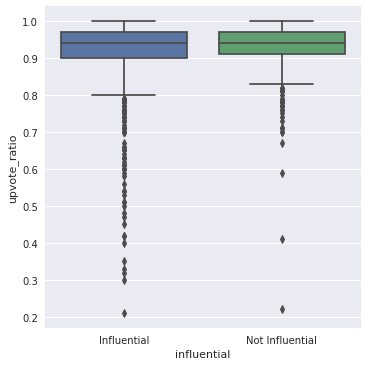

In [ ]:
posts_boxplot = posts_by_influential.append(posts_by_not_influential)
sns.catplot(x='influential', y='upvote_ratio', kind='box', data=posts_boxplot)

It seems like the posts of influential and non-influential users are about equally well-received.

Next, we make a bar plot of the percent of posts in each topic by both types of users.

Text(0.5, 1.0, 'Influential/Non-Influential Post Author Topics')

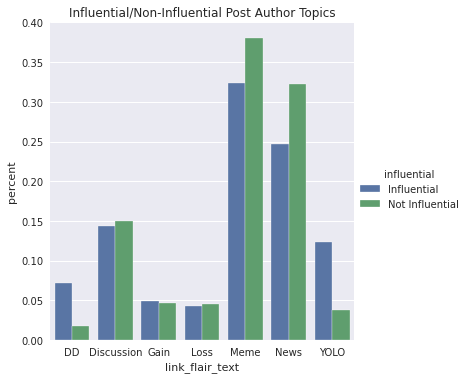

In [ ]:
posts_plot = sqldf('select link_flair_text, influential, count(*) as post_count '
                    'from posts_boxplot group by link_flair_text, influential')
flairs = ['Discussion','YOLO','News','Loss','Gain', 'DD', 'Meme']
posts_plot = posts_plot[posts_plot['link_flair_text'].isin(flairs)]

posts_plot = sqldf('select y.link_flair_text, y.influential, y.post_count, cast(y.post_count as float) / x.total as percent from posts_plot y '
'join (select influential, sum(post_count) as total from posts_plot group by influential) x on '
'y.influential = x.influential')
sns.catplot(x='link_flair_text', y='percent', hue='influential', data=posts_plot, kind='bar')
plt.title('Influential/Non-Influential Post Author Topics')
# sns.catplot(x='link_flair_text', y='post_count', hue='influential', data=posts_plot, kind='bar')

Interestingly, people seem to not care as much about who posts memes and news, but consistently influential users dominate the YOLO and DD (stock research) categories.

This makes sense because users are more likely to make a name for themselves by posting a surprising stock analysis or a crazy investment choice (YOLO) than by posting a meme or news.

We use SVD to group words in posts by influential users into topics and compare these to those by non-influential users.

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

svd = TruncatedSVD(n_components=100, random_state=2021)
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
tfidf_vector = tfidf.fit_transform(posts_by_influential['title'])
svd_result = svd.fit_transform(tfidf_vector)

vocab = np.array(tfidf.get_feature_names())

num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

n_topics = 20
show_topics(svd.components_[:n_topics])

['2021 march thread discussion daily moves tomorrow february',
 'posting rules please read wsb edition smoothbrain gme',
 'discussion thread daily weekend february january 28 part',
 'gme megathread march yolo update amc rkt mar',
 'gme yolo update february april mar stock like',
 'update yolo march mar rkt gamestop stock like',
 'april update yolo mar 2021 megathread rkt 13',
 'stock like april megathread weekend gamestop rkt 05',
 'february megathread weekend 2021 stock like part rkt',
 'weekend march squeeze 19 05 26 12 amc',
 'gamestop stop megathread robinhood reddit squeeze buy still',
 'squeeze gamma big short squoze calculator part explained',
 'week next wsb hedge funds rkt still megathread',
 'hold line squeeze shares buy coming hands us',
 'amc still squeeze moon short yet february rkt',
 'stop holding still yolo game loss wallstreetbets like',
 'part january 28 amc still holding weekend 29',
 'still wsb going us holding financial melvin im',
 'still hold week gamestop selli

As you can see from the posts of consistently upvoted users above, there are **discussions/threads** likely posted by moderators (such as `OPINION_IS_UNPOPULAR`), **YOLO updates** posted by `DeepFuckingValue`, as well as **motivational posts** from other users analyzing the meme stocks and suggesting that a short squeeze will happen soon.

Next, we'll take a look at clusters of topics from users who aren't consistently popular.

In [ ]:
svd = TruncatedSVD(n_components=100, random_state=2021)
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
tfidf_vector = tfidf.fit_transform(posts_by_not_influential['title'])
svd_result = svd.fit_transform(tfidf_vector)

vocab = np.array(tfidf.get_feature_names())

num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

n_topics = 20
show_topics(svd.components_[:n_topics])

['gme still like holding buy stock today wsb',
 'still holding 300 bought holdin 59k else brethren',
 'like stock wsb fucking still selling 26 buy',
 'hands diamond wsb apes see go together space',
 'buy wsb sell right never robinhood silver gamestop',
 'buy sell diamond hands never today hold call',
 'hold sell fucking apes go panic sign say',
 'apes together buy strong go us today beautiful',
 'sell say robinhood never retards funds selling hedge',
 'retards boys moon get one go market let',
 'retards market today one hold open wsb weekend',
 'today sell boys wsb never say stonks moon',
 'robinhood trading today gamestop wallstreetbets stonks day halted',
 'right today sell guys go robinhood diamond please',
 'go moon see amc right stock never going',
 'selling moon fucking go gamestop shares buy say',
 'sign wallstreetbets know market walking god guys cnbc',
 'gamestop back boys cnbc today say right market',
 'sign boys say robinhood wsb know sell god',
 'selling see today robinhood

It seems that these non-influential users tend to post morale-boosting phrases such as "diamond hands," "apes together strong," "to the moon," and complaining about Robinhood and hedge funds.

It makes sense that no one remembers the names of these users because they don't stand out much from each other.

On the other hand, the influential users like DFV built their reputations by posting million-dollar bets and posting detailed stock research.

## II. **Posts**

### 1. What percentage of each column is null? Is this different for the top and bottom 1000 posts by upvote count?

In [ ]:
all_dict = {'column': [], 'not_null': []}
top_1000_dict = {'column': [], 'not_null': []}
bottom_1000_dict = {'column': [], 'not_null': []}

for column in ['title', 'body', 'user', 'close']:
  all_dict['column'].append(column)
  top_1000_dict['column'].append(column)
  bottom_1000_dict['column'].append(column)

  # counts how many rows have a value for this column
  all_dict['not_null'].append(posts_stock_data.sort_values(by='score', ascending=False)[column].notnull().sum() / len(posts_stock_data))
  top_1000_dict['not_null'].append(posts_stock_data.sort_values(by='score', ascending=False)[column][:1000].notnull().sum() / 1000)
  bottom_1000_dict['not_null'].append(posts_stock_data.sort_values(by='score', ascending=True)[column][:1000].notnull().sum() / 1000)

It appears that as the number of upvotes on a post decreases, more posts have text in their body and more are posted by deleted users.

Based on non-null stock data (closing price), posts with fewer upvotes tend to be slightly more on weekdays compared to those with the most upvotes. 

[Text(0.5, 1.0, 'Bottom 1000 Posts')]

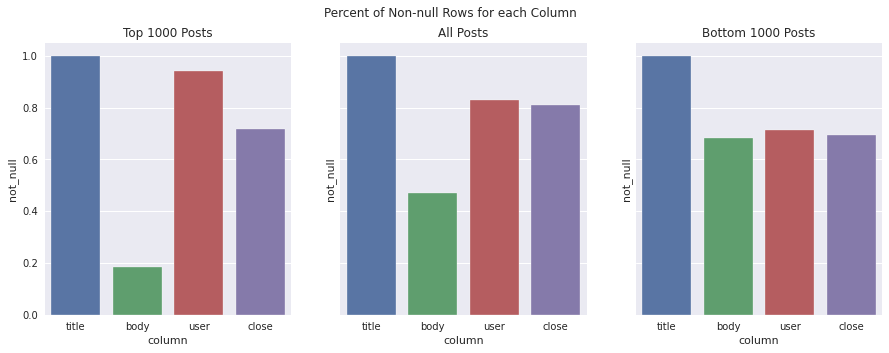

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
fig.suptitle('Percent of Non-null Rows for each Column')
g1 = sns.barplot(ax=ax1, x='column', y='not_null', data=pd.DataFrame.from_dict(top_1000_dict))
g1.set(title='Top 1000 Posts')
g2 = sns.barplot(ax=ax2, x='column', y='not_null', data=pd.DataFrame.from_dict(all_dict))
g2.set(title='All Posts')
g3 = sns.barplot(ax=ax3, x='column', y='not_null', data=pd.DataFrame.from_dict(bottom_1000_dict))
g3.set(title='Bottom 1000 Posts')

### 2. What is the post volume over time?

We plot post volume over time using plotly.

There's an extremely large spike in post volume from 1197 on Jan 28 to 15,693 on Jan 29, but it drops back to 1424 by Jan 30. This might be more related to how strict the moderators of the subreddit are than to actual number of attempted posts.

In [ ]:
date_vols = sqldf('select date, count(date) as post_volume from posts_clean group by date')
# date_vols = sqldf('select date_vols.date, post_volume, Volume as gme_volume from date_vols left join gme_df on date_vols.date = gme_df.Date')
fig = px.line(date_vols.sort_values(by='date')[:], x='date', y='post_volume', title='Number of WSB Reddit Posts Per Day')
fig.show()

### 3. What does the correlation matrix look like?

We plot a correlation heatmap.

Text(0.5, 1.0, 'Correlation Matrix for Post Data')

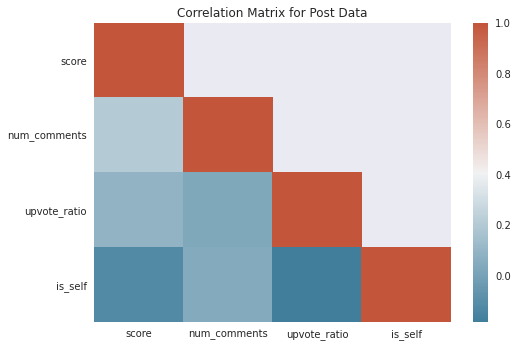

In [ ]:
corr = posts_clean.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
sns.heatmap(corr, cmap=cmap, mask=mask)
plt.title('Correlation Matrix for Post Data')

There is a weak positive correlation between score and number of comments, and a very weak positive correlation between score/comments and upvote ratio.

We can also see that whether a post consists of only text tends to have a weak negative correlation with score and upvote ratio.

### 4. What are the most popular posts by score?

Let's first take a look at the top 20 highest-scoring posts!
(Comment out last line to see the dataframe)

In [ ]:
top20_posts_df = sqldf('SELECT * FROM posts_drop_null_users ORDER BY score DESC LIMIT 20')
# top20_posts_df

---
**Initial Observations**

1. Most popular posts tend to have nothing in the body, which suggests they could be posts containing only images, gifs, or other media. This can also be seen in that a majority of these top posts are *not* selfposts (posts containing only text).
2. Specific users, such as `DeepFuckingValue`, `game_stone`, and `keenfeed` seem to appear multiple times. It is worth looking into what role these users are playing in the whole  community 
3. Most popular posts appear to be posted around late January to early February - specifically January 28th to February 3rd. It is worth looking into whether this is correlated with GME performance in the stock market.
4. `YOLO`, `Meme`, and `News` flairs appear to dominate the posts flairs in these top posts. To determine whether a particular flair more often predict post popularity, we will have to take a closer look later.

---

Given the above observations, let's try to see what the data tells us.



### 5. What qualities are common in the most popular posts?

#### A. Looking at word frequencies in title

First, we define some functions to help us tokenize the post titles.

In [ ]:
import re
import nltk
from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# list of stopwords
stopwords = set(stopwords.words('english'))

# function that removes bad characters in a text
def remove_punctuation(text):
    return re.sub("[!-/:-@[-`{-~—']", '', text)

# function to tokenize string, remove if not alphabetic, convert to lowercase, and remove if is stopword
def tokenize_content(text):
  tokens = nltk.word_tokenize(text)
  tokens = [token for token in tokens if token.isalpha()]
  tokens = [token.lower() for token in tokens]
  return [word for word in tokens if word.lower() not in stopwords]

  
# function that counts the words appearing in title
def count_frequency(df):
  # remove punctuation from and tokenize title
  title_tokenized = [tokenize_content(remove_punctuation(row)) for row in df['title']]
  # flatten list
  title_flattened_tokens = [item for sublist in title_tokenized for item in sublist]
  return Counter(title_flattened_tokens)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


One way we can measure post popularity is through score. Specifically, the higher the score, the more popular the post.

In [ ]:
# obtain top 1000 scoring posts by score
top1000_posts_by_score = posts_drop_null_users.sort_values('score', ascending=False)[:1000]

# obtain word frequencies of top 1000 posts by score
top1000_frequencies_by_score = count_frequency(top1000_posts_by_score)

# obtain top 20 most popular words by score
top1000_most_common_by_score = top1000_frequencies_by_score.most_common(20)
print(top1000_most_common_by_score)

[('gme', 243), ('wsb', 57), ('robinhood', 47), ('megathread', 43), ('still', 41), ('hold', 41), ('gamestop', 40), ('stock', 39), ('like', 37), ('buy', 36), ('holding', 36), ('us', 34), ('get', 31), ('going', 30), ('apes', 30), ('short', 30), ('back', 28), ('im', 28), ('market', 26), ('hedge', 25)]


Another way we can measure post popularity is through upvote ratio. Specifically, the higher the `upvote_ratio`, the more popular the post!

In [ ]:
# obtain top 1000 scoring posts by ratio
top1000_posts_by_ratio = posts_drop_null_users.sort_values('upvote_ratio', ascending=False)[:1000]

# obtain word frequencies of top 1000 posts by ratio
top1000_frequencies_by_ratio = count_frequency(top1000_posts_by_ratio)

# obtain top 20 most popular words by ratio
top1000_most_common_by_ratio = top1000_frequencies_by_ratio.most_common(20)
print(top1000_most_common_by_ratio)

[('gme', 185), ('robinhood', 165), ('buy', 116), ('hold', 108), ('amc', 70), ('sell', 57), ('trading', 47), ('us', 46), ('market', 42), ('still', 40), ('let', 36), ('app', 35), ('dont', 35), ('stock', 35), ('nok', 31), ('get', 31), ('like', 30), ('going', 30), ('rh', 29), ('im', 29)]


While `score` and `upvote_ratio` are valid and arguably good measures of post popularity, they introduce some unwanted biases. 

While a post with a high score may be popular, it's also possible that it is controversial. In other words, a post that has relatively lower `upvote_ratio` can still have a significant amount of net upvotes (`score`). 

In addition, a post with high `upvote_ratio` may not necesssarily be popular. For example, a post with 1 upvote and 0 downvotes has 1.0 `upvote_ratio`, but if the user upvoted his/her own post... that post may not actually be very popular. 

Consequently, we will use a combination of `upvote_ratio` and score. Specifically, we will score by `score`, but also require that the `upvote_ratio` exceed 0.90.

In [ ]:
# obtain top 1000 scoring posts by mixing
top1000_posts_mixed = posts_drop_null_users[posts_drop_null_users['upvote_ratio'] >= 0.90].sort_values('score', ascending=False)[:1000]

# obtain word frequencies of top 1000 posts by mixing
top1000_frequencies_mixed = count_frequency(top1000_posts_mixed)

# obtain top 20 most popular words by mixing
top1000_most_common_mixed = top1000_frequencies_mixed.most_common(20)
print(top1000_most_common_mixed)

[('gme', 221), ('robinhood', 53), ('wsb', 48), ('gamestop', 42), ('still', 41), ('stock', 39), ('buy', 38), ('hold', 38), ('us', 37), ('holding', 36), ('like', 34), ('shares', 32), ('today', 32), ('back', 30), ('short', 30), ('time', 29), ('apes', 28), ('get', 28), ('going', 27), ('market', 26)]


Let's take a look at the most common words in the top 1000 posts using the mixed method. 

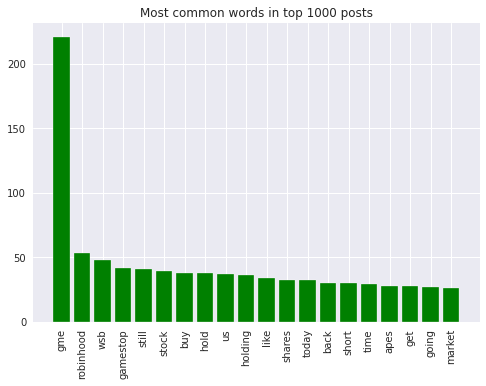

In [ ]:
word_list = [tuple[0] for tuple in top1000_most_common_mixed]
frequency_list = [tuple[1] for tuple in top1000_most_common_mixed]

plt.bar(word_list, frequency_list, color='green')
plt.xticks(rotation=90)
plt.title('Most common words in top 1000 posts')
plt.show()

Similar to how we measured post popularity, one way to measure post *un*popularity is through score. 

In [ ]:
# obtain lowest scoring posts (min score was 0)
bottom1000_posts_by_score = posts_drop_null_users[posts_drop_null_users['score'] == 0].sort_values('num_comments', ascending=False)[:1000]

# obtain word frequencies of bottom 1000 posts
bottom1000_frequencies_by_score = count_frequency(bottom1000_posts_by_score)

# obtain top 20 most popular words 
bottom1000_most_common_by_score = bottom1000_frequencies_by_score.most_common(20)
print(bottom1000_most_common_by_score)

[('gme', 217), ('stock', 66), ('short', 59), ('buy', 59), ('discussion', 53), ('daily', 52), ('thread', 52), ('squeeze', 48), ('amc', 48), ('unpinned', 47), ('going', 45), ('sell', 44), ('next', 36), ('go', 34), ('im', 34), ('money', 32), ('get', 32), ('like', 31), ('robinhood', 30), ('gamestop', 29)]


Another way to measure post unpopularity is through upvote ratio. Specifically, the lower the `upvote_ratio`, the more unpopular the post.

In [ ]:
# obtain lowest scoring posts by upvote ratio
bottom1000_posts_by_ratio = posts_drop_null_users.sort_values('upvote_ratio')[:1000]

# obtain word frequencies of bottom 1000 posts by upvote ratio
bottom1000_frequencies_by_ratio = count_frequency(bottom1000_posts_by_ratio)

# obtain top 20 most popular words by upvote ratio
bottom1000_most_common_by_ratio = bottom1000_frequencies_by_ratio.most_common(20)
print(bottom1000_most_common_by_ratio)

[('gme', 194), ('buy', 90), ('stock', 71), ('short', 63), ('next', 62), ('squeeze', 48), ('new', 43), ('going', 43), ('ag', 42), ('sell', 41), ('get', 37), ('money', 36), ('like', 36), ('amc', 34), ('lets', 30), ('gamestop', 27), ('one', 26), ('stocks', 25), ('im', 25), ('people', 25)]


Using `score` and `upvote_ratio` alone may not be the optimal measures of unpopularity, however.

An issue that can arise with just taking the posts with lowest `score` is that the Reddit API automatically sets a `score` floor of 0, which means there are a significant amount of posts with a `score` of 0.

The issue that arises with `upvote_ratio` is similar to the issue we had with post popularity. If 0 users upvote a post and 1 user downvotes a post, the `upvote_ratio` will be 0.0, but it does not necessarily suggest that this post is *extremely* unpopular.

To calculate unpopularity, then, we will try to adjust the latter issue. In other words, we will considered post unpopularity using `upvote_ratio` but account for the issue with making sure the number of comments exceeds a certain value. Note that by sorting on `upvote_ratio`, we are in a way sorting by `score` (since `upvote_ratio` will a score of <= 0.5 get score of 0).

In [ ]:
# obtain lowest scoring posts (min score was 0)
bottom1000_posts_mixed = posts_drop_null_users[posts_drop_null_users['num_comments'] > 50].sort_values('upvote_ratio')[:1000]

# obtain word frequencies of bottom 1000 posts
bottom1000_frequencies_mixed = count_frequency(bottom1000_posts_mixed)

# obtain top 20 most popular words 
bottom1000_most_common_mixed = bottom1000_frequencies_mixed.most_common(20)
print(bottom1000_most_common_mixed)

[('gme', 242), ('rkt', 64), ('stock', 62), ('discussion', 62), ('amc', 61), ('daily', 60), ('short', 59), ('squeeze', 58), ('thread', 57), ('unpinned', 53), ('dd', 49), ('holding', 41), ('like', 39), ('money', 36), ('next', 34), ('dont', 33), ('going', 33), ('market', 32), ('buy', 32), ('march', 30)]


Let's visualize the most common words in the bottom 1000 most unpopular posts.

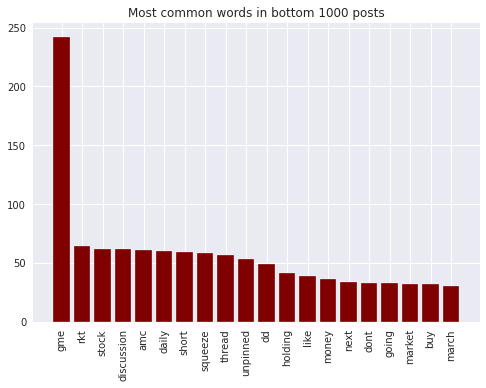

In [ ]:
word_list = [tuple[0] for tuple in bottom1000_most_common_mixed]
frequency_list = [tuple[1] for tuple in bottom1000_most_common_mixed]

plt.bar(word_list, frequency_list, color='maroon')
plt.xticks(rotation=90)
plt.title('Most common words in bottom 1000 posts')
plt.show()

Since there seems to be some terms, such as `gme`, that we may expect to frequently appear both in most and least popular posts, to gauge word that *more frequently* appear in popular posts, we use a Counter.

In [ ]:
distinct_highest_counter = top1000_frequencies_mixed - bottom1000_frequencies_mixed
distinct_lowest_counter = bottom1000_frequencies_mixed - top1000_frequencies_mixed

distinct_highest_common = distinct_highest_counter.most_common(20)
print(distinct_highest_common)

distinct_lowest_common = distinct_lowest_counter.most_common(20)
print(distinct_lowest_common)

[('robinhood', 31), ('sec', 20), ('wsb', 19), ('gamestop', 18), ('cnbc', 18), ('apes', 18), ('back', 16), ('update', 14), ('trying', 14), ('bought', 14), ('boys', 14), ('still', 13), ('hold', 13), ('diamond', 13), ('today', 13), ('us', 13), ('funds', 12), ('strong', 12), ('cuban', 11), ('see', 11)]
[('rkt', 63), ('discussion', 60), ('daily', 57), ('unpinned', 53), ('thread', 53), ('dd', 44), ('squeeze', 38), ('amc', 36), ('short', 29), ('march', 25), ('stock', 23), ('interest', 23), ('gme', 21), ('think', 21), ('next', 19), ('play', 17), ('money', 16), ('please', 16), ('uwmc', 15), ('sold', 14)]


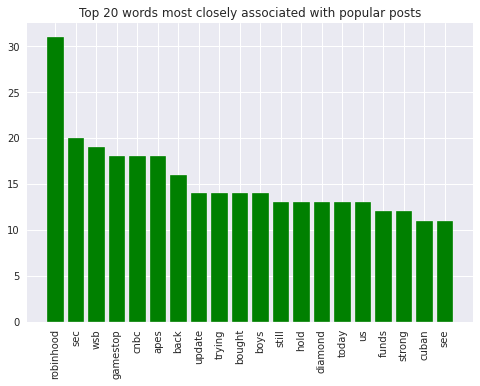

In [ ]:
word_list = [tuple[0] for tuple in distinct_highest_common]
frequency_list = [tuple[1] for tuple in distinct_highest_common]

plt.bar(word_list, frequency_list, color='green')
plt.xticks(rotation=90)
plt.title('Top 20 words most closely associated with popular posts')
plt.show()

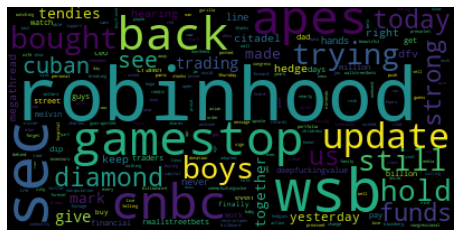

In [ ]:
highest_wordcloud = WordCloud(background_color='black')
highest_wordcloud.generate_from_frequencies(distinct_highest_counter)
plt.imshow(highest_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

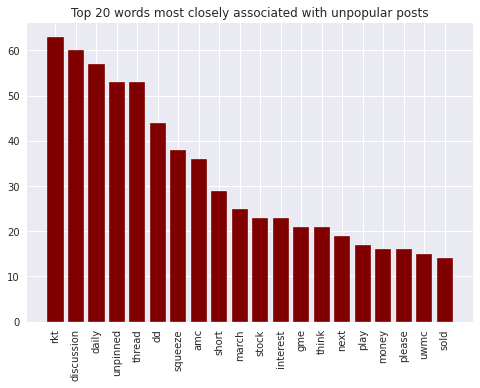

In [ ]:
word_list = [tuple[0] for tuple in distinct_lowest_common]
frequency_list = [tuple[1] for tuple in distinct_lowest_common]

plt.bar(word_list, frequency_list, color='maroon')
plt.xticks(rotation=90)
plt.title('Top 20 words most closely associated with unpopular posts')
plt.show()

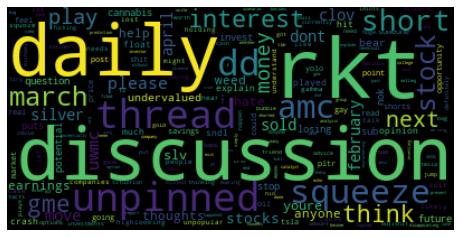

In [ ]:
lowest_wordcloud = WordCloud(background_color='black')
lowest_wordcloud.generate_from_frequencies(distinct_lowest_counter)
plt.imshow(lowest_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Analysis**

* In comparison with unpopular posts, popular posts tends to be more News- or Morale-Boost-focused. Words such as `robinhood`, `sec`, and `cnbc` are likely used in posts that attempt to call out Robinhood, a financial service company with a popular (or not so popular anymore) trading app, for restricting trade on GME and other news sources for spreading false information. Words such as `apes`, `boys`, `still`, `hold`, `diamond`, and `strong` are likely used for rallying other *wallstreetbets* users. 
* In comparison with popular posts, unpopular posts appear to contain more words related to discussion threads or general conversation, such as `discussion`, `daily`, `unpinned`, `thread`, `dd`. It's not surprising that such posts may be more unpopular, since posts that invite conversation may lend itself to being more controversial. These posts also tend to talk about other stocks, like \$AMC or \$RKT. Such posts may be unwanted by many *wallstreetbets* users as they prefer to focus their attention and efforts on \$GME.


#### B. Are there users who dominate the top 1000 posts?

As can be seen in the bar plot below, `OPINION_IS_UNPOPULAR` and `DeepFuckingValue` have many Top 1000 posts.

This is not surprising, as `OPINION_IS_UNPOPULAR` is a *wallstreetbets* moderator and hence posts many threads, such as daily discussions. Additionally, `DeepFuckingValue` is often attributed to bringing attention to the high short interest in \$GME, so it's also no surprise his posts become very popular. 

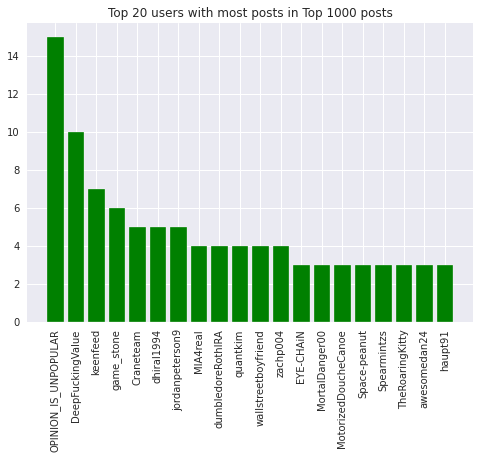

In [ ]:
top20_users = sqldf('SELECT user, COUNT(*) as num_posts FROM top1000_posts_mixed GROUP BY user ORDER BY num_posts DESC LIMIT 20')

plt.bar(top20_users['user'], top20_users['num_posts'], color='green')
plt.xticks(rotation=90)
plt.title('Top 20 users with most posts in Top 1000 posts')
plt.show()

It seems like `AutoModerator` gets downvoted quite often. Perhaps *wallstreetbets* users are sick of the redundant/repetitive mod posts. 

Users like `Bscrob` are labeled as 'troll accounts.'

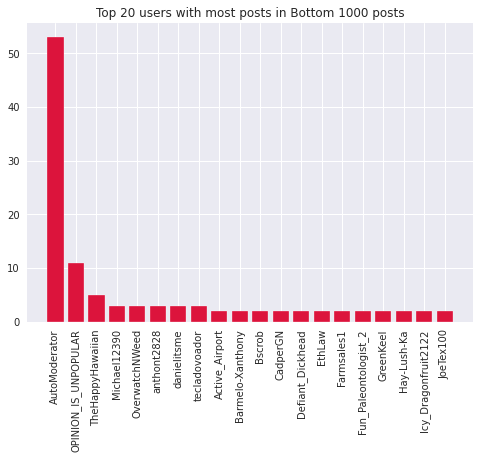

In [ ]:
bottom20_users = sqldf('SELECT user, COUNT(*) as num_posts FROM bottom1000_posts_mixed GROUP BY user ORDER BY num_posts DESC LIMIT 20')

plt.bar(bottom20_users['user'], bottom20_users['num_posts'], color='crimson')
plt.xticks(rotation=90)
plt.title('Top 20 users with most posts in Bottom 1000 posts')
plt.show()

#### C. Do popular posts usually contain images, gifs, and other media?

Self posts are posts containing only text, without links to images or other sites.

In [ ]:
percent_top_selfposts = len(top1000_posts_mixed[top1000_posts_mixed['is_self'] == True]) / 1000
percent_bottom_selfposts = len(bottom1000_posts_mixed[bottom1000_posts_mixed['is_self'] == True]) / 1000

print('The percentage of top 1000 posts that are selfposts: ', percent_top_selfposts)
print('The percentage of bottom 1000 posts that are selfposts: ', percent_bottom_selfposts)

The percentage of top 1000 posts that are selfposts:  0.171
The percentage of bottom 1000 posts that are selfposts:  0.77


There are significantly lower selfposts in the Top 1000 posts compared to the bottom 1000 posts. 

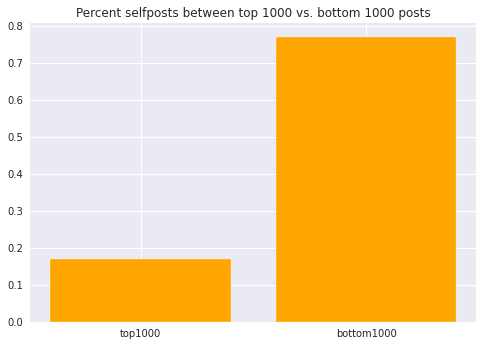

In [ ]:
cat = ['top1000', 'bottom1000']
pct = [percent_top_selfposts, percent_bottom_selfposts]
plt.bar(cat, pct, color='orange')
# plt.xticks(rotation=90)
plt.title('Percent selfposts between top 1000 vs. bottom 1000 posts')
plt.show()

#### D. Are certain flairs associated with more or less popular posts?

First, we calculate the number of posts (`num_posts`), average score of posts (`avg_score`), the average upvote ratio (`avg_upvote_ratio`), and percent of total posts (`percent`) associated with each flair type.

In [ ]:
# Obtain total number, percentage, average score, and average upvote ratio of posts by flair
posts_by_flair = sqldf('SELECT link_flair_text AS flair, COUNT(*) AS num_posts, AVG(score) as avg_score, AVG(upvote_ratio) as avg_upvote_ratio FROM posts_drop_null_users GROUP BY flair')
# posts_by_flair = sqldf('SELECT *, CAST(num_posts AS float) / 37651.0 AS percent FROM posts_by_flair')
posts_by_flair = sqldf('SELECT *, CAST(num_posts AS float) / (select count(*) from posts_drop_null_users) AS percent FROM posts_by_flair')
posts_by_flair['flair'] = posts_by_flair['flair'].astype('str')
posts_by_flair.sort_values('percent', ascending=False).head()

,flair,num_posts,avg_score,avg_upvote_ratio,percent
5,Discussion,11980,810.128881,0.832605,0.318185
31,YOLO,6841,991.363690,0.855825,0.181695
19,News,4658,4393.592744,0.899178,0.123715
14,Loss,3617,833.301078,0.861183,0.096067
11,Gain,3203,1261.654699,0.827986,0.085071


In [ ]:
# we must convert None instances to string 'None' in order to plot
def convert_none(text):
  if text == None:
    return 'None'
  else:
    return text

From initially looking at each flair type with the highest `avg_score`, we see that `Hang In There`, `Technical ART`, `Science`, and `Cheers Mate` seem to dominate the category.

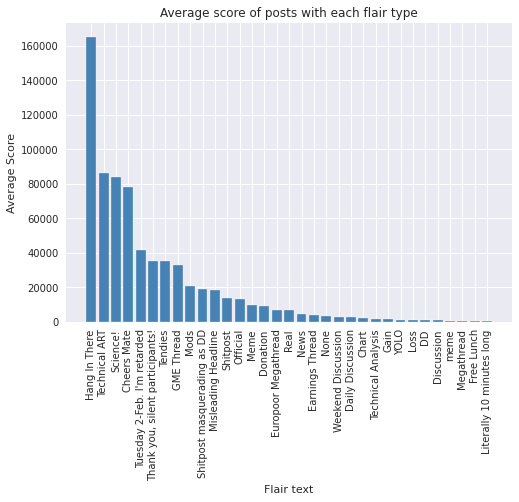

In [ ]:
# sort posts by score and upvote ratio
posts_flair_by_score = sqldf('SELECT flair, avg_score FROM posts_by_flair ORDER BY avg_score DESC')
# matplotlib colors https://matplotlib.org/stable/gallery/color/named_colors.html
plt.bar(posts_flair_by_score['flair'], posts_flair_by_score['avg_score'], color='steelblue')
plt.xticks(rotation=90)
plt.title('Average score of posts with each flair type')
plt.xlabel('Flair text')
plt.ylabel('Average Score')
plt.show()

However, it's likely that the average score is so high due to a low number of posts in each category.

Text(0, 0.5, '% of posts')

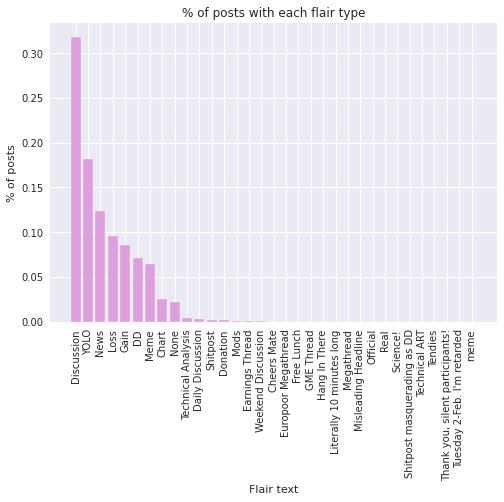

In [ ]:
# convert flair None column to 'None'
# posts_by_flair['flair'] = [convert_none(text) for text in posts_by_flair['flair']]

posts_flair_by_percent = sqldf('SELECT flair, percent FROM posts_by_flair ORDER BY percent DESC')

# matplotlib colors https://matplotlib.org/stable/gallery/color/named_colors.html
plt.bar(posts_flair_by_percent['flair'], posts_flair_by_percent['percent'], color='plum')
plt.xticks(rotation=90)
plt.title('% of posts with each flair type')
plt.xlabel('Flair text')
plt.ylabel('% of posts')

When considering popularity using `upvote_ratio`, we see that many flairs exceed an average `upvote_ratio` of 0.90. As observed in Part A, posts associated with `DD` or `Discussion/Threads` seem to be less popular.

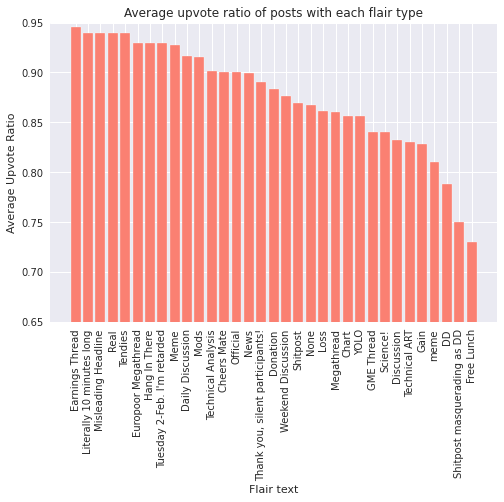

<Figure size 144x72 with 0 Axes>

In [ ]:
posts_flair_by_upvote_ratio = sqldf('SELECT flair, avg_upvote_ratio FROM posts_by_flair ORDER BY avg_upvote_ratio DESC')
# matplotlib colors https://matplotlib.org/stable/gallery/color/named_colors.html
plt.bar(posts_flair_by_upvote_ratio['flair'], posts_flair_by_upvote_ratio['avg_upvote_ratio'], color='salmon')
plt.xticks(rotation=90)
plt.title('Average upvote ratio of posts with each flair type')
plt.xlabel('Flair text')
plt.ylabel('Average Upvote Ratio')
plt.ylim([0.65, 0.95])
plt.figure(figsize=(2,1))
plt.show()

When observing the frequency of flairs for the Top 1000 and Bottom 1000 most popular posts as calculated earlier, we see some noticeable differences.

* As expected, posts with flairs `Discussion` and `DD` dominate the least popular posts. Note that a little over 30% of all posts are marked with the `Discussion` flair, but over 50% of the bottom 1000 posts are `Discussion` posts. Similarly, although `DD` makes up about 6% of all posts, over 20% of the bottom 1000 posts are comprised of `DD`. 
* `Meme` and `News` post tend to be associated with more popular posts. Although `Meme` posts only comprise of about 6% of total posts, `Meme` posts dominate the top 1000 posts, with over 30% of the top 1000 posts having flair type `Meme`. Similarly, although `News` make up a little over 10% of total posts, almost 30% of the top 1000 posts are `News` related.

Text(0.5, 1.0, '% posts w/ flair in bottom 1000 posts')

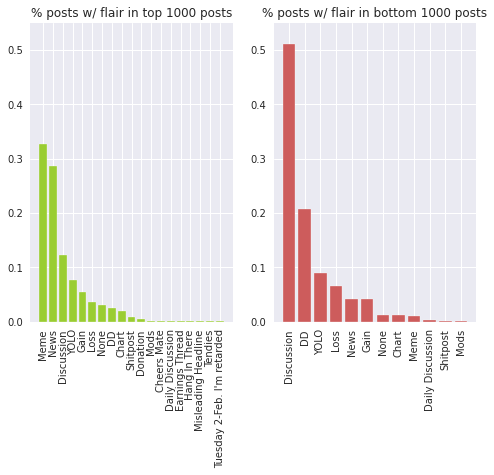

In [ ]:
top1000_posts_mixed_convert_none = top1000_posts_mixed
top1000_posts_mixed_convert_none['link_flair_text'] = [convert_none(text) for text in top1000_posts_mixed_convert_none['link_flair_text']]
top1000_posts_mixed_flairs = sqldf('SELECT link_flair_text AS flair, COUNT(*) as num_posts FROM top1000_posts_mixed_convert_none GROUP BY link_flair_text ORDER BY num_posts DESC')
top1000_posts_mixed_flairs = sqldf('SELECT *, CAST(num_posts AS float) / 1000.0 AS percent FROM top1000_posts_mixed_flairs')
top1000_posts_mixed_flairs['flair'] = top1000_posts_mixed_flairs['flair'].astype('str')

bottom1000_posts_mixed_convert_none = bottom1000_posts_mixed
bottom1000_posts_mixed_convert_none['link_flair_text'] = [convert_none(text) for text in bottom1000_posts_mixed_convert_none['link_flair_text']]
bottom1000_posts_mixed_flairs = sqldf('SELECT link_flair_text AS flair, COUNT(*) as num_posts FROM bottom1000_posts_mixed_convert_none GROUP BY link_flair_text ORDER BY num_posts DESC')
bottom1000_posts_mixed_flairs = sqldf('SELECT *, CAST(num_posts AS float) / 1000.0 AS percent FROM bottom1000_posts_mixed_flairs')
bottom1000_posts_mixed_flairs['flair'] = bottom1000_posts_mixed_flairs['flair'].astype('str')

plt.subplot(1, 2, 1)
plt.bar(top1000_posts_mixed_flairs['flair'], top1000_posts_mixed_flairs['percent'], color='yellowgreen')
plt.xticks(rotation=90)
plt.ylim([0.0, 0.55])
plt.title('% posts w/ flair in top 1000 posts')

plt.subplot(1, 2, 2)
plt.bar(bottom1000_posts_mixed_flairs['flair'], bottom1000_posts_mixed_flairs['percent'], color='indianred')
plt.xticks(rotation=90)
plt.ylim([0.0, 0.55])
plt.title('% posts w/ flair in bottom 1000 posts')

### 6. What do post wordclouds look like?

#### A. What does the wordcloud for all posts look like?

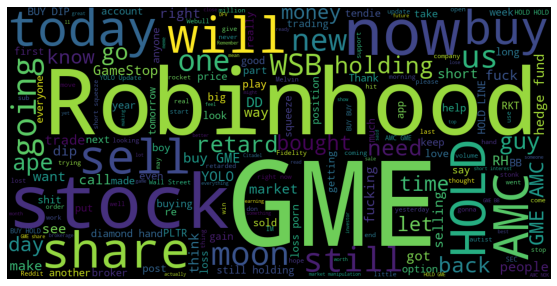

In [ ]:
def text(df_text):
    text = [string for string in df_text]
    text = ''.join(text)
    return text
title_text = text(posts_stock_data['title'])

wordcloud = WordCloud(width=1000, height=500)
wordcloud.generate(title_text)
plt.figure(figsize=(10, 5))
plt.axis(False)
plt.imshow(wordcloud)

Unsurprisingly, we see words such as "GME", "Robinhood", "stock", and HOLD" as most common words mentioned in post titles. 

#### B. What does the Postive vs Negative vs Neutral Sentiment Wordclouds look like?
Here, we use a sentiment analysis tool to determine whether WSB posts are positive, negative, or neutral. This sentiment mining tool we use today is called the VADER (Valence Aware Dictionary and sEntiment Reasoner) tool. For more information, read here: https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

VADER is a parsimonious rule-based model developed by a group of Georgia Tech researchers for sentiment analysis of social media text. Their paper for more information: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [ ]:
def determine_sentiment(post):
    if sid.polarity_scores(post)["compound"] > 0:
        return "Positive"
    elif sid.polarity_scores(post)["compound"] < 0:
        return "Negative"
    else:
        return "Neutral"  

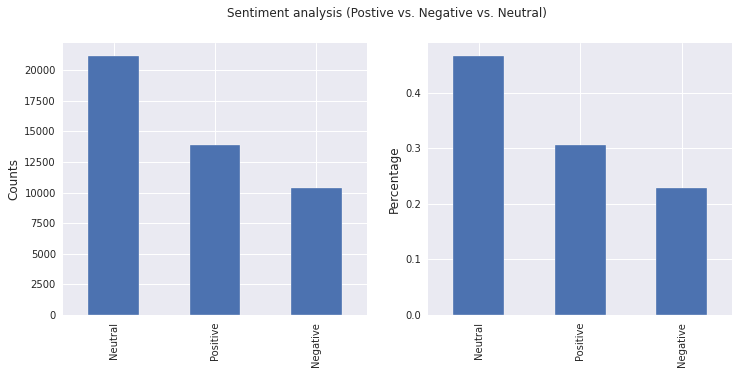

In [ ]:
def plot_sentiment(df, feature, title):
    counts = df[feature].value_counts()
    percent = counts/sum(counts)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    counts.plot(kind='bar', ax=ax1)
    percent.plot(kind='bar', ax=ax2)
    ax1.set_ylabel(f'Counts', size=12)
    ax2.set_ylabel(f'Percentage', size=12)
    plt.suptitle(f"Sentiment analysis (Postive vs. Negative vs. Neutral)")
    # plt.tight_layout()
    plt.show()

posts_stock_data['title_sentiment'] = posts_stock_data['title'].apply(lambda x: determine_sentiment(x))
plot_sentiment(posts_stock_data, 'title_sentiment', 'Title')

According to the sentiment analysis breakdown of postive vs negative titles, we see there appears to be more neutral and positive titles than negative. This is interesting since there might be many hedge fund analysts that would disagree with this analysis. 

##### Positive Wordcloud

(-0.5, 999.5, 499.5, -0.5)

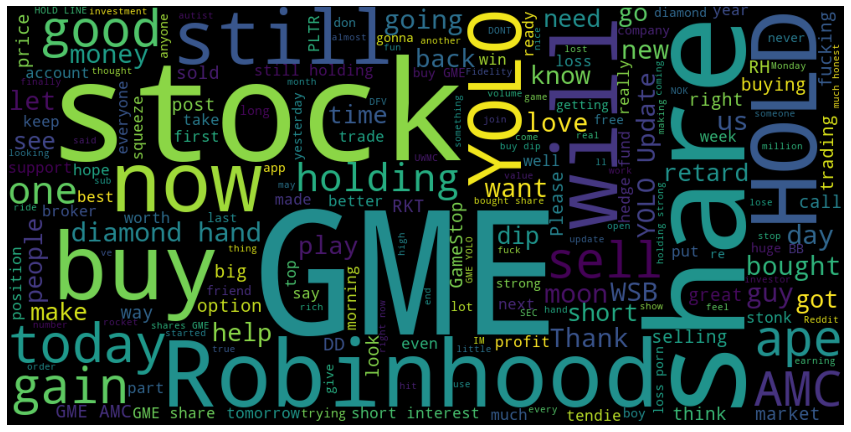

In [ ]:
positive_texts = text(posts_stock_data.loc[posts_stock_data['title_sentiment']=='Positive', 'title'])
wordcloud = WordCloud(width = 1000, height = 500).generate(positive_texts)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

#show_wordcloud(posts_clean.loc[posts_clean['title_sentiment']=='Neutral', 'title'], title = 'Word Cloud for Neutral Sentiment)')

##### Negative Wordcloud

(-0.5, 999.5, 499.5, -0.5)

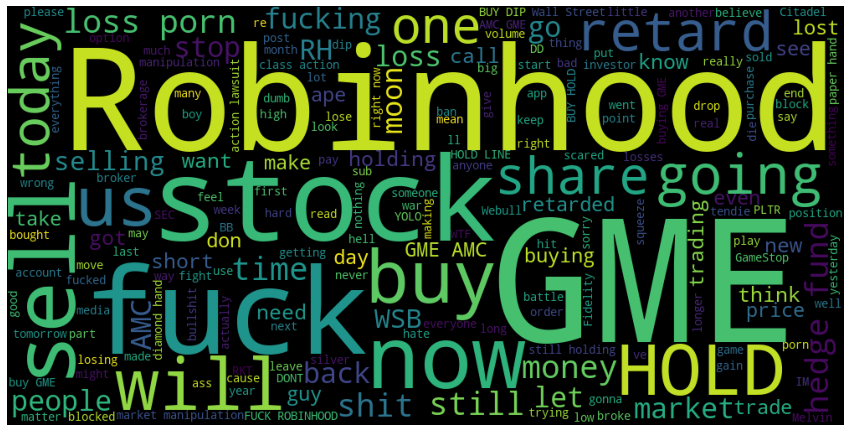

In [ ]:
negative_texts = text(posts_stock_data.loc[posts_stock_data['title_sentiment']=='Negative', 'title'])
wordcloud = WordCloud(width = 1000, height = 500).generate(negative_texts)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

##### Neutral Wordcloud

(-0.5, 999.5, 499.5, -0.5)

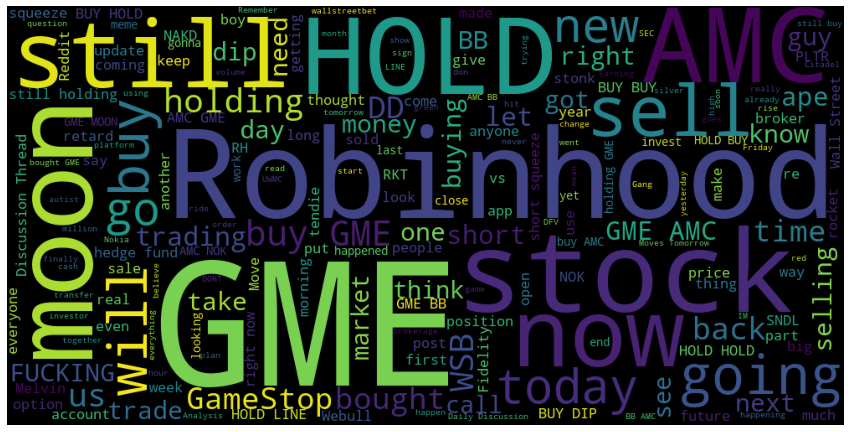

In [ ]:
neutral_texts = text(posts_stock_data.loc[posts_stock_data['title_sentiment']=='Neutral', 'title'])
wordcloud = WordCloud(width = 1000, height = 500).generate(neutral_texts)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

The three above wordclouds show most common words for different sentiments. We can see that there are common words in each, such as "GME", "Robinhood", "AMC", "stock", and "hold". However, we see that in the negative wordcloud, there contains more inappropriate and swear words. Because the wordclouds are very similar, we recognize that it may not be very helpful in predicting variables such as stock prices. One thing that we mention in potential next steps is creating an algorithm that is better at separating the sentiment of these posts than VADER. 

## III. **Emojis!**

### 1. What are the most common emojis?

In [ ]:
!pip install spacymoji
!pip install spacy

import spacy
from spacymoji import Emoji
from spacy.language import Language
!python -m spacy download en_core_web_sm 

     |████████████████████████████████| 12.8MB 6.5MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 9.1MB 18.5MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 460kB 26.3MB/s 
     |████████████████████████████████| 1.1MB 45.0MB/s 
     |████████████████████████████████| 122kB 55.4MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp37-none-any.whl size=49716 sha256=baf54f30d9a2c471bdfbb76b2ae31b8047fa5da005aa91b0421a65de6fc1c802
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107098 sha256=c81ce2cfd43129f13853f3c28bd5b08c2aa0a1ca1018aaed0fa9985a61472633
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built emoji smart-open
  Found existing installation: smart-open 5.0.0
    U

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=['parser'])
emoji = Emoji(nlp, merge_spans=False)

nlp.add_pipe("emoji", first = True)

In [ ]:
def extract_emoji(sent):
    doc = nlp(sent)
    res = ' '.join([token.text for token in doc if token._.is_emoji])
    return res.strip()

In [ ]:
import re
from collections import Counter

posts_stock_data['emojis_title'] = posts_stock_data.title.transform(extract_emoji)
c = Counter([emoji for sent in posts_stock_data.emojis_title.to_list() for emoji in set(sent) if emoji!=' '])

In [ ]:
most_common_emojis = pd.DataFrame.from_dict(
    dict(c.most_common()), orient='index', columns=['emojis_title']
)
most_common_emojis = most_common_emojis[most_common_emojis['emojis_title']>1].index[:6].to_list()
most_common_emojis

['🚀', '💎', '🙌', '🦍', '👐', '🤲']

According to the above analysis, we see the most common emojis are: 🚀,💎, 🙌, 🦍, 👐, and 🤲. We try to define those emojis below:

🚀: This emoji usually refers to "Going to the moon" and refers to the fact that a stock grows.

💎: Diamond. It goes together with 🙌, which means "Diamonds Hands". It measures how likely a trader is to sell if the price drops or if they make a modest profit. Diamonds means they will not sell. Otherwise they have "paper" hands.

✋: Hands-related emojis could be related to diamond and paper hands or other supportive messages.

🦍: One common phrase is "apes together strong" and seems to derive directly from Rise of Planet of Apes. The "apes" are the retail investors that, if they are united, they could be strong enough to outlast those short on the stock.

Comment out the below code to view some example posts containing the emojis:

In [ ]:
#posts_stock_data[posts['title'].str.contains('💎', case=False) | posts['title'].str.contains('🚀', case=False) | 
#                 posts['title'].str.contains('🙌', case=False) | posts['title'].str.contains('🦍', case=False) |
#                 posts['title'].str.contains('👐', case=False) | posts['title'].str.contains('🤲', case=False)]].sample(5)

### 2. How many posts contain emojis?

In [ ]:
titles_with_emojis = len(posts[posts['title'].str.contains('💎', case=False) | posts['title'].str.contains('🚀', case=False) | 
          posts['title'].str.contains('🙌', case=False) | posts['title'].str.contains('🦍', case=False) |
          posts['title'].str.contains('👐', case=False) | posts['title'].str.contains('🤲', case=False)])

titles_without_emojis = len(posts['title'])
percentage_emojis = titles_with_emojis / titles_without_emojis
print(titles_with_emojis)
print(percentage_emojis)

7240
0.15939412619435517


We see that there are 7,240 instances of titles with the top 6 emojis, which is about 16% of all titles. 

## IV. **GME Data**

### 1. What does daily GME trading volume in dollar value look like?

In [ ]:
dollar_volume = sqldf('select date, volume * close as dollars from gme_df')
fig = px.line(dollar_volume, x='date', y='dollars', title='Daily GME Trading Volume in Dollar Value')
fig.show()

### 2. What does daily GME closing price look like over time?

In [ ]:
fig = px.line(gme_df, x='date', y='close', title='Daily GME Closing Price')
fig.show()

### 3. Which days were the most volatile? `(high-low/low)`

In [ ]:
intraday = sqldf('select Date, (high-low) / low as intraday from gme_df')
fig = px.line(intraday, x='date', y='intraday', title='Daily GME Maximum Intraday Percent Change')
fig.show()

As shown in the charts above, dollar trading volume of more than $32 billion spiked up on January 27th. This effect can also be shown on the closing price as well as percent change in price. 

### 4. What is the correlation between `open` vs `high` price and other prices during the day?

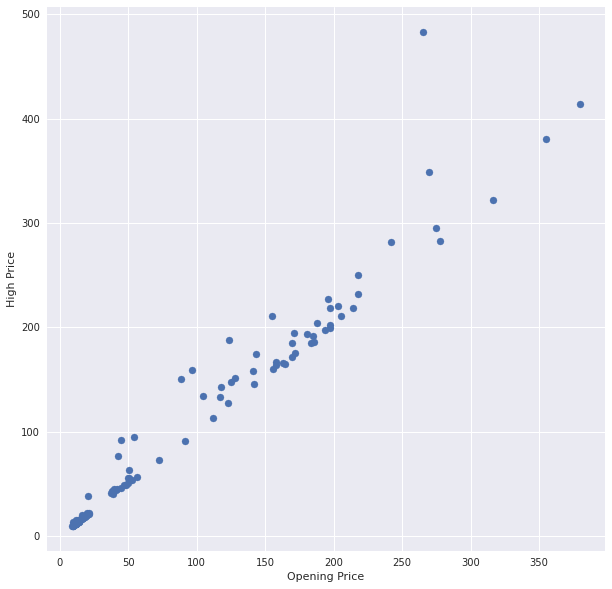

In [ ]:
#Open price vs high price
x = np.array(gme_df.loc[:,'open']).reshape(-1,1)
y = np.array(gme_df.loc[:,'high']).reshape(-1,1)

plt.figure(figsize=[10,10])
plt.scatter(x, y)
plt.xlabel('Opening Price')
plt.ylabel('High Price')
plt.show()

As shown in the graph above (Opening Price vs High Price), we can see there might be a linearity to a large extent as far as it is observed. 

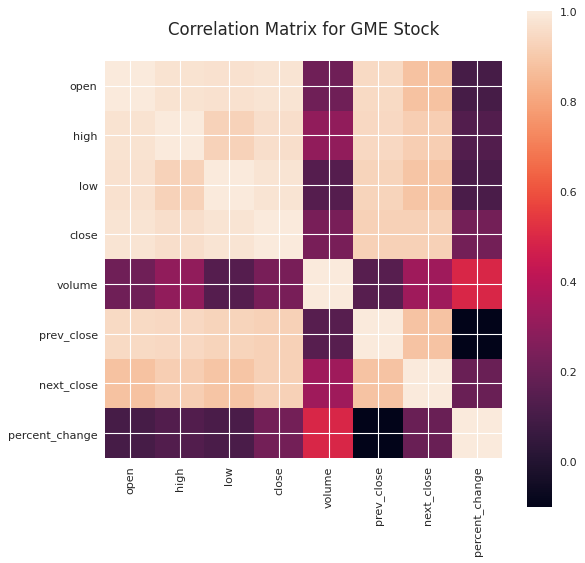

In [ ]:
def plotCorrelationMatrix(df, graphWidth):
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for GME Stock', fontsize=15)
    plt.show()
plotCorrelationMatrix(gme_df, 8)

We can see in the correlation table that trading volume has a moderate correlation with prices in a given day. In most of our analysis to follow, we use closing price since investors, traders, financial institutions, regulators and other stakeholders use it as a reference point for determining performance over a specific time such as one year, a week and over a shorter time frame such as one minute or less.

# **Modeling**

First, we import the necessary libraries.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

## 1. Can we predict post flair using text of the title?

Most of the posts are labeled with a flair such as "News", "Discussion", "Gain", "Loss", or "Meme".

Can we classify the topic of a post based on the text of its title?

### A. Using Logistic Regression

First, we try a Logistic regression model using tf-idf scores to predict the top 7 flair categories.

In [ ]:
le = LabelEncoder()
posts_title_flair = posts[['title', 'link_flair_text']]
flairs = ['Discussion','YOLO','News','Loss','Gain', 'DD', 'Meme']
posts_title_flair = posts_title_flair[posts_title_flair['link_flair_text'].isin(flairs)]
posts_title_flair['title'] = posts_title_flair['title'].astype('string')
posts_title_flair['link_flair_text'] = posts_title_flair['link_flair_text'].astype('string')
posts_title_flair['flair'] = le.fit_transform(posts_title_flair['link_flair_text'])

X_train, X_test, y_train, y_test = train_test_split(posts_title_flair['title'], posts_title_flair['flair'], test_size=0.2, random_state=2021)

tfidf = TfidfVectorizer()
tfidf_lr = Pipeline([('vect', tfidf), ('lr', LogisticRegression(max_iter=500, class_weight=None))])
tfidf_lr.fit(X_train, y_train)
pred = tfidf_lr.predict(X_test)

print("Test accuracy: " + str(accuracy_score(y_test, pred)))
print("Training accuracy: " + str(accuracy_score(y_train, tfidf_lr.predict(X_train))))

Test accuracy: 0.5152649432682185
Training accuracy: 0.625


This seems promising, considering how simple the model is.

From the confusion matrix, we can see that Discussion and News are hard to distinguish, and Gains and Losses are often mislabeled as YOLO.

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

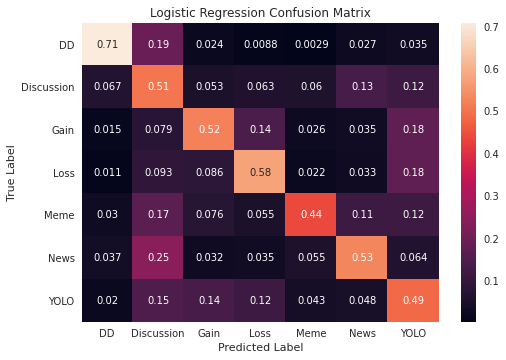

In [ ]:
cm = confusion_matrix(pred, y_test, normalize='true')
labels = le.inverse_transform(list(range(len(flairs))))
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')

In [ ]:
lr_results = pd.DataFrame(X_test)
lr_results['predicted'] = le.inverse_transform(pred)
lr_results['actual'] = le.inverse_transform(y_test)
lr_results.sample(20)

,title,predicted,actual
42119,YOLO using 100K of margin to buy Palantir and ...,YOLO,YOLO
28827,Just letting you know,News,News
17068,Sorry I came late with this one bois 😔 (from m...,Meme,Meme
31166,Fuck Robinhood. I’m still holding. $GME $AMC,Loss,Loss
9655,"""Help me get more Tendies"" - u/DeepFucking Val...",Meme,Meme
2371,I just bought more shares on Merrill and execu...,YOLO,Discussion
19415,Spread the word! 💎🤲,Discussion,News
16748,What BS,Discussion,News
17959,Picturing in 70+ years our grandkids will be a...,News,YOLO
43563,Who needs ETFs when you can average down?!,Discussion,YOLO


### B. Using Random Forest

We try using a random forest with 50 decision trees to predict post flair from title text.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(posts_title_flair['title'], posts_title_flair['flair'], 
                                                    test_size=0.2, random_state=2021)
rf = RandomForestClassifier(n_estimators=50)
tfidf = TfidfVectorizer()
tfidf_rf = Pipeline([('vect', tfidf), ('rf', rf)])
tfidf_rf.fit(X_train, y_train)
pred = tfidf_rf.predict(X_test)

print("Test accuracy: " + str(accuracy_score(y_test, pred)))
print("Training accuracy: " + str(accuracy_score(y_train, tfidf_rf.predict(X_train))))

Test accuracy: 0.48356532927827817
Training accuracy: 0.973093121197941


Since the train accuracy is much higher than test accuracy, there seems to be overfitting. However, decreasing the number of trees lowered test accuracy, which is why we chose n_estimators = 50.

Text(0.5, 1.0, 'Random Forest Confusion Matrix')

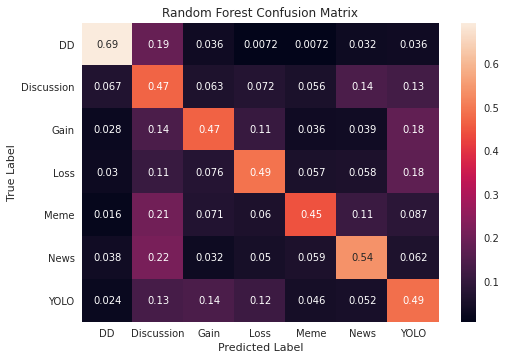

In [ ]:
cm = confusion_matrix(pred, y_test, normalize='true')
labels = le.inverse_transform(list(range(len(flairs))))
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')

### C. Using Neural Network

We train a neural network on post titles following this example from the PyTorch tutorials:

https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

In [ ]:
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
posts_title_flair = posts[['title', 'link_flair_text']]
flairs = ['Discussion','YOLO','News','Loss','Gain', 'DD', 'Meme']
posts_title_flair = posts_title_flair[posts_title_flair['link_flair_text'].isin(flairs)]
posts_title_flair['title'] = posts_title_flair['title'].astype('string')
posts_title_flair['link_flair_text'] = posts_title_flair['link_flair_text'].astype('string')
posts_title_flair['flair'] = le.fit_transform(posts_title_flair['link_flair_text'])

#### Prepare Dataset

In [ ]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

class TextDataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y
    self.max = len(x)
    self.n = 0
  
  def __iter__(self):
    self.n = 0
    return self

  def __next__(self):
    if self.n < self.max:
      result = (self.y[self.n], self.x[self.n])
      self.n += 1
      return result
    else:
      raise StopIteration
  
  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.y[index], self.x[index]

X_train, X_test, y_train, y_test = train_test_split(posts_title_flair['title'], posts_title_flair['flair'], 
                                                    test_size=0.2, random_state=2021)

text_train_iter = TextDataset(X_train.reset_index(drop=True), y_train.reset_index(drop=True))
text_test_iter = TextDataset(X_test.reset_index(drop=True), y_test.reset_index(drop=True))

text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
label_pipeline = lambda x: int(x)# - 1

In [ ]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

tokenizer = get_tokenizer('basic_english')
counter = Counter()
for (label, line) in text_train_iter:
  counter.update(tokenizer(line))
vocab = Vocab(counter, min_freq=1)

In [ ]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)    

dataloader = DataLoader(text_train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

#### Model

In [ ]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [ ]:
num_class = len(set([label for (label, text) in text_train_iter]))
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [ ]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

#### Run the Model

In [ ]:
from torch.utils.data.dataset import random_split
# Hyperparameters
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training
  
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
# train_iter, test_iter = AG_NEWS()
train_iter, test_iter = text_train_iter, text_test_iter
# train_dataset = train_iter
# test_dataset = test_iter
train_dataset = list(train_iter)
test_dataset = list(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/  508 batches | accuracy    0.413
-----------------------------------------------------------
| end of epoch   1 | time:  2.24s | valid accuracy    0.420 
-----------------------------------------------------------
| epoch   2 |   500/  508 batches | accuracy    0.466
-----------------------------------------------------------
| end of epoch   2 | time:  2.17s | valid accuracy    0.436 
-----------------------------------------------------------
| epoch   3 |   500/  508 batches | accuracy    0.493
-----------------------------------------------------------
| end of epoch   3 | time:  2.20s | valid accuracy    0.459 
-----------------------------------------------------------
| epoch   4 |   500/  508 batches | accuracy    0.516
-----------------------------------------------------------
| end of epoch   4 | time:  2.06s | valid accuracy    0.450 
-----------------------------------------------------------
| epoch   5 |   500/  508 batches | accuracy    0.545
------

#### Evaluating the Model

In [ ]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.493


In [ ]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return torch.argmax(output, 1).item()

Test accuracy: 0.4926892034156042


Text(0.5, 1.0, 'Confusion Matrix Neural Network')

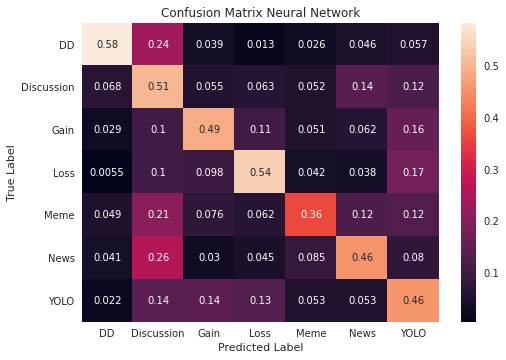

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pred = X_test.apply(predict, args=[text_pipeline])
print("Test accuracy: " + str(accuracy_score(y_test, pred)))
cm = confusion_matrix(pred, y_test, normalize='true')
labels = le.inverse_transform(list(range(len(flairs))))
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Neural Network')

### Results

The logistic regression model turned out to perform the best, with 50.9% test accuracy. The neural network was next best with 49.4%, and then the random forest model had 48.6% accuracy.

One reason for why all three models performed about the same is that post categories are not so clearly defined. For example, many posts labeled as "Discussion" could also be placed under "Meme" or "News" categories. Also, "Gain" and "Loss" posts could just as easily have been labeled as "YOLO" because they all involve risky financial decisions.

We can see that our models had difficulty distinguishing these from the confusion matrices.

Considering these factors, our models performed pretty well classifying the 7 categories. We could use them to label the posts with no flair or posts from other sites like Twitter to get a rough idea of what topics people are posting about.

## 2. Is there a correlation b/w price increase/decrease and post points? Is there a correlation b/w closing price and points?
* Here we will look to see if there is any correlation between `percent_change` in price with the number of post points (`score`). We also see what the correlation between `percent_change` and `close` price is. Then we run a linear regression. 



In [ ]:
postspoints_stockchange = posts_stock_data[['percent_change', 'score', 'close']]

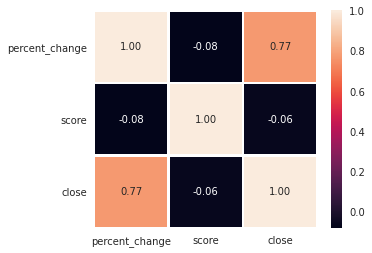

In [ ]:
#correlation matrix
plt.subplots(figsize=(5,4))
sns.heatmap(postspoints_stockchange.drop(columns=[]).corr(), annot=True, linewidths=1.5, fmt=".2f");

There seems to be little direct correlation between `price_change` and `score`; however there seems to be a strong correlation between `price_change` and `close` price.

What if we made `percent_change` into a categorical variable where negative percentage change = decrease (-1) and positive percentage change = increase (+1) and no change = neutral (0)?

In [ ]:
postspoints_stockchange['stock_change'] = np.sign(postspoints_stockchange['percent_change'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



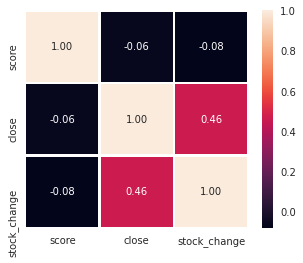

In [ ]:
plt.subplots(figsize=(5,4))
sns.heatmap(postspoints_stockchange.drop(columns=['percent_change']).corr(), annot=True, linewidths=1.5, fmt=".2f");

Once changed to a categorical variable, `percent_change` seems to have worse correlation with both. We perform a simple linear regression; however, since there is already very little correlation with `score`, we expect the linear regression to perform poorly relative to `close`.

In [ ]:
#clean data
postspoints_stockchange['score'] = postspoints_stockchange['score'].astype(float)
postspoints_stockchange = postspoints_stockchange.dropna()

#linear regression with both close and score
x = postspoints_stockchange[['score', 'close']] 
y = postspoints_stockchange.iloc[:, 0]
lr_model = LinearRegression()
model = lr_model.fit(x,y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.5988831425470746


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
model.coef_

array([-1.53412002e-06,  2.90724083e-03])

The linear regression had a ~60% r-square, which means the model explains ~60% of variability of `percent_change` variable. However, the coeficient are quite small, meaning a small change in any of the variables won't change the outcome by much. 

## 3. Can we predict whether a post will become popular?

Predicting whether a post will get more than 1000 upvotes based on title

In [ ]:
# popular = 2*(posts_stock_data['score'] > 1000) + ((posts_stock_data['score'] < 1000) & (posts_stock_data['score'] > 100))
# 1 for popular, 0 for not popular
popular = (posts_stock_data['score'] > 100).astype(int)
popular.value_counts()

0    28761
1    16661
Name: score, dtype: int64

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



Logistic regression: 0.6858558062740782
Training accuracy: 0.7492913559182101


Text(0.5, 1.0, 'Post Popularity Confusion Matrix')

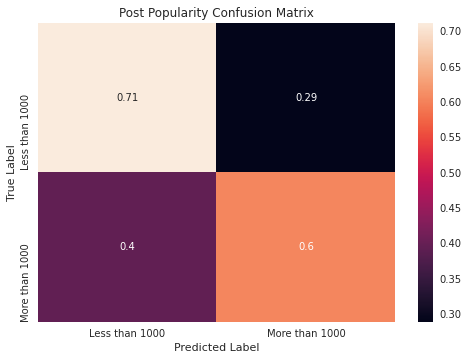

In [ ]:
from imblearn.over_sampling import RandomOverSampler 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(posts_stock_data['title'], popular, test_size=0.2, random_state=2021)
# print(X_train)
# ros = RandomOverSampler(random_state=42)
# X_res, y_res = ros.fit_resample(X_train, y_train)

tfidf = TfidfVectorizer()
tfidf_lr = Pipeline([('vect', tfidf), ('lr', LogisticRegression(max_iter=1000))])
tfidf_lr.fit(X_train, y_train)
pred = tfidf_lr.predict(X_test)

print("Logistic regression: " + str(accuracy_score(y_test, pred)))

# rand_pred = np.random.randint(0, 2, len(y_test))
# rand_pred = np.random.random(len(y_test)) > 0.8105
# print("Guessing randomly: " + str(accuracy_score(y_test, rand_pred)))
# print("Guessing all 0: " + str(accuracy_score(y_test, np.zeros(len(y_test)))))
print("Training accuracy: " + str(accuracy_score(y_train, tfidf_lr.predict(X_train))))

pred = tfidf_lr.predict(X_test)
cm = confusion_matrix(pred, y_test, normalize='true')
labels = ['Less than 1000', 'More than 1000']
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Post Popularity Confusion Matrix')

In [ ]:
results = pd.DataFrame(X_test)
results['true'] = y_test
results['pred'] = pred
results.sample(10)

,title,true,pred
27494,Whats wrong with moderator???,0,0
29752,Wonder where we've seen this before,0,0
32239,PDC Newsletter: Trading Week Ending 2/12,1,0
31567,The truth that has been overlooked by many.,0,0
38297,I put 20K Gain from $RKT options straight into...,1,1
15082,OCDX goes ipo any minute! Alllllll aboard for ...,0,0
22086,PSI TO GME AMC HOLDERS,1,1
15668,Trading 2-1-2 sold my stocks without my permis...,0,0
37908,"My Theory on what happened today in $RKT, and ...",1,0
9964,SEC needs to stop all trading until we are giv...,0,0


Let's see if `post_flair_text` is able to predict whether a post will reach `score > 100`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Logistic regression: 0.6453611898016998
Training accuracy: 0.6460254221210396


Text(0.5, 1.0, 'Post Popularity Confusion Matrix')

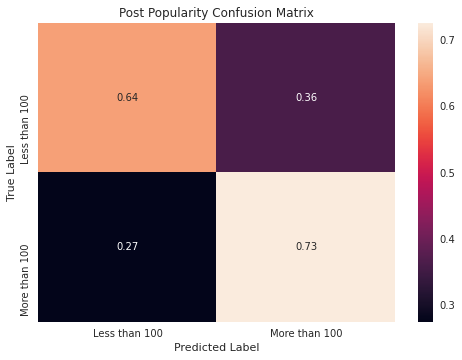

In [ ]:
posts_prediction = posts_drop_null_users[['score', 'num_comments', 'upvote_ratio', 'is_self', 'link_flair_text' ]]
posts_prediction['link_flair_text'] = [convert_none(text) for text in posts_prediction['link_flair_text']]
X = pd.get_dummies(posts_prediction[['link_flair_text']])
y = (posts_prediction['score'] > 100).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

scl = StandardScaler()
pca = PCA()
lr = LogisticRegression(max_iter=1000)
pipe = Pipeline([('Scale', scl), ('PCA', pca), ('lr', lr)])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("Logistic regression: " + str(accuracy_score(y_test, pred)))
print("Training accuracy: " + str(accuracy_score(y_train, pipe.predict(X_train))))

pred = pipe.predict(X_test)
cm = confusion_matrix(pred, y_test, normalize='true')
labels = ['Less than 100', 'More than 100']
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Post Popularity Confusion Matrix')

As can be seen, there is not a significant amount of learning that's going on, as our model tends to predict only slightly better than if it were to guess 0 (a score of less than 100) on all posts.

Let's try this with predicting whether the post as over 90% upvote ratio.

Logistic regression: 0.5244334277620396
Training accuracy: 0.5738569531398217


Text(0.5, 1.0, 'Post Popularity Confusion Matrix')

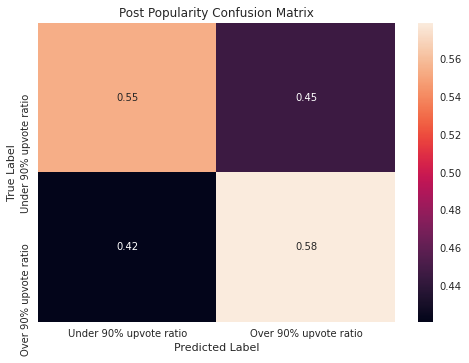

In [ ]:
y = (posts_prediction['upvote_ratio'] > 0.90).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

pipe.fit(X_train, y_train)
print("Logistic regression: " + str(accuracy_score(y_test, pred)))
print("Training accuracy: " + str(accuracy_score(y_train, pipe.predict(X_train))))

pred = pipe.predict(X_test)
cm = confusion_matrix(pred, y_test, normalize='true')
labels = ['Under 90% upvote ratio', 'Over 90% upvote ratio']
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Post Popularity Confusion Matrix')

Although our model seems to be learning a little, the difference is still not very high.

If we try to combine both the `is_self` and `link_flair_text` as features, our model still doesn't predict all that well.

Logistic regression: 0.6531515580736544
Training accuracy: 0.6495162208309618


Text(0.5, 1.0, 'Post Popularity Confusion Matrix')

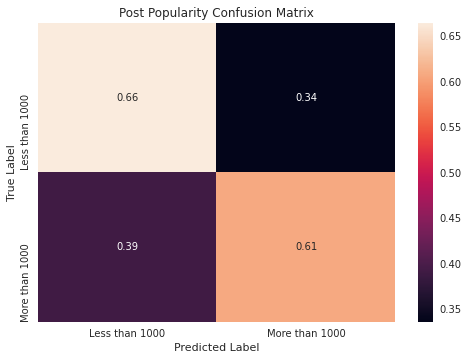

In [ ]:
X = pd.concat([posts_prediction[['is_self']], pd.get_dummies(posts_prediction[['link_flair_text']])], axis=1)
y = (posts_prediction['score'] > 100).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print("Logistic regression: " + str(accuracy_score(y_test, pred)))
print("Training accuracy: " + str(accuracy_score(y_train, pipe.predict(X_train))))

pred = pipe.predict(X_test)
cm = confusion_matrix(pred, y_test, normalize='true')
labels = ['Less than 1000', 'More than 1000']
sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Post Popularity Confusion Matrix')

## 4. Can we use sentiment analysis to better understand market performance?



We explore using WSB sentiment data to inform trading strategies. We derive market sentiment in two ways usign the WSB subreddit:
1. We run a VADER sentiment model (recall the wordcloud section under the exploratory data analysis) to assess overall daily possitive/negative/neutral sentiment. 
2. We assess daily bullish/bearish sentiment using keyword analysis.





In [ ]:
analyser = SentimentIntensityAnalyzer()
scores=[]
for titles in posts_stock_data['title']:
    sentiment_score=analyser.polarity_scores(titles)['compound']
    
    scores.append(sentiment_score)
    
posts_stock_data['sentiment_score_title'] = scores

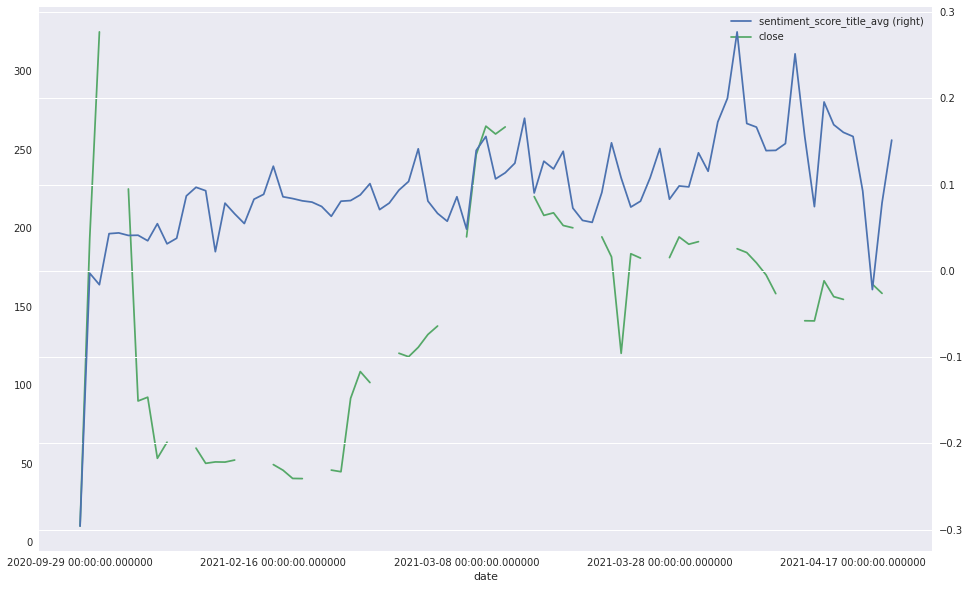

In [ ]:
avg_sentiment_data = sqldf('select date, avg(sentiment_score_title) as sentiment_score_title_avg, close from posts_stock_data group by date')
#plot for sentiment score against the GME price
avg_sentiment_data = avg_sentiment_data[['date', 'sentiment_score_title_avg', 'close']]
avg_sentiment_data = avg_sentiment_data.set_index('date')
avg_sentiment_data.plot(secondary_y='sentiment_score_title_avg', figsize=(16, 10))

## 5. Does the number of WSB posts on any given day correlate with the stock price of $GME?



In our stock analysis, we would first like to test whether there is a correlation between the number of WSB posts and the stock price of Gamestop.

In [ ]:
posts_stockprice = sqldf('select date, count(title) as Number_of_posts, close, open, high, low, volume * close as volume_value from posts_stock_data group by date')

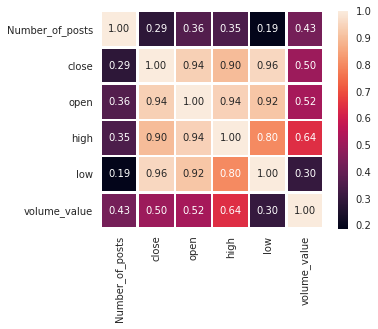

In [ ]:
#correlation matrix
plt.subplots(figsize=(5,4))
sns.heatmap(posts_stockprice.drop(columns=[]).corr(), annot=True, linewidths=1.5, fmt=".2f");

We see that there is a moderate positive correlation between the number of posts per day and the total value of shares traded, which makes sense because this reflects interest in the stock.

## 6. Does a significant drop or rise in $GME price predict more WSB posts containing the word 'HOLD'?


We define a "significant" drop in \$GME price as less than -10%. 

In [ ]:
#make indicator variables for significant drop/rise and WSB posts with word "HOLD"
titles=posts_stock_data['title'].tolist()
titles=list([(title.lower()) for title in titles])
stock_prices = posts_stock_data['percent_change'].tolist()

hold_word =['hold']

contains_hold =[]
sig_change = []
for title in titles:
    hold=False
    for word in hold_word:
        if word in title:
            hold = True
    if re.findall(r'(\b\d{1,4}[c]\b)|(\b\d{1,4}[ ][c]\b)', title):
            bull=True
            
    if hold==True:
      contains_hold.append(1)
    if hold == False:
      contains_hold.append(0)
for price in stock_prices:
    if price > 0.1:
      sig_change.append(1)
    elif price < -0.1:
      sig_change.append(-1)
    else:
      sig_change.append(0)
  

posts_stock_data['contains_hold']= contains_hold
posts_stock_data['sig_change'] = sig_change

We do a logistic regression. 

In [ ]:
hold_change_data = posts_stock_data[['contains_hold', 'sig_change']]
hold_change_data = hold_change_data.dropna()
y = hold_change_data.contains_hold.copy()
X = hold_change_data[['sig_change']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = pd.Series(model.predict(X_test))
y_test = y_test.reset_index(drop=True)
z = pd.concat([y_test, y_pred], axis=1)
z.columns = ['True', 'Prediction']
z.head(10)

,True,Prediction
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,0


In [ ]:
import sklearn.metrics as metrics
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.8906989543203082
Precision: 0.0
Recall: 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Text(0.5, 28.5, 'Predicted')

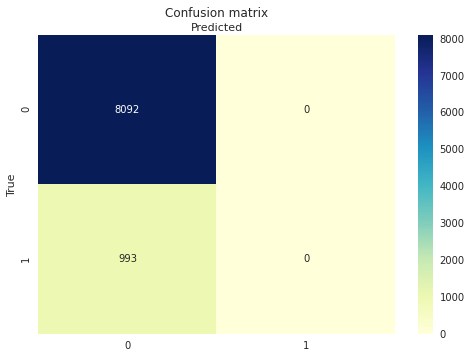

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.title('Confusion matrix', y=1.1)
plt.ylabel('True')
plt.xlabel('Predicted')

It looks like the accuracy for the logistic regression is around 89%, which seems very good; however, if we take a closer look at the confusion matrix, we see that we have 0 precision. It seems like the predicted values are just predicted to be 0. Therefore, we don't believe a signficant drop or rise in $GME stock can predict more WSB posts containing the word "HOLD". 

## 7. Can we use sentiment analysis to classify titles as Bullish vs Bearish?
We use a *small* collection of keywords to classify submission titles as bullish, bearish, or neutral. Using regex to detect positions in the WSB titles, we classify each of these in the following manner: titles containing call positions are classified as bullish while titles containing put positions are classified as bearish.

In [ ]:
titles=posts_stock_data['title'].tolist()
titles=list([(title.lower()) for title in titles])

bull_words=['call', 'long', 'all in', 'moon', 'going up', 'rocket', 'buy', 'long term', 'green']
bear_words=['put', 'short', 'going down', 'drop', 'bear', 'sell', 'red']

#classify!
bull_scores=[]
bear_scores=[]
for title in titles:
    bull=False
    bear=False
    for word in bull_words:
        if word in title:
            bull=True
    if re.findall(r'(\b\d{1,4}[c]\b)|(\b\d{1,4}[ ][c]\b)', title):
            bull=True
            
    for word in bear_words:
        if word in title:
            bear=True
    if re.findall(r'(\b\d{1,4}[p]\b)|(\b\d{1,4}[ ][p]\b)', title):
            bear=True
            
    if bull==True and bear==True:
        bull_scores.append(0)
        bear_scores.append(0)
    if bull==False and bear==False:
        bull_scores.append(0)
        bear_scores.append(0)
    if bull==True and bear==False:
        bull_scores.append(1)
        bear_scores.append(0)
    if bull==False and bear==True:
        bull_scores.append(0)
        bear_scores.append(1)
        
posts_stock_data['bull_score']=bull_scores
posts_stock_data['bear_score']=bear_scores

In [ ]:
# "normalize" scores by day
scores_df = sqldf('select date, sum(bull_score) as bull_score_sum, sum(bear_score) as bear_score_sum, close from posts_stock_data group by date')
scores_df['bull_score']=scores_df['bull_score_sum']/scores_df.count()['bull_score_sum']
scores_df['bear_score']=scores_df['bear_score_sum']/scores_df.count()['bear_score_sum']

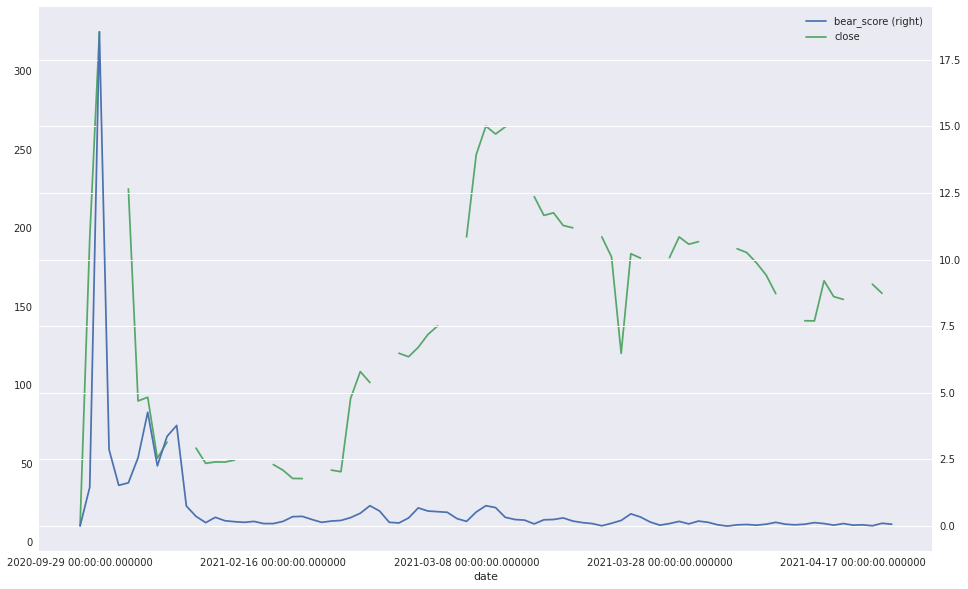

In [ ]:
scores_df_bear = scores_df[['bear_score', 'date', 'close']]
scores_df_bear = scores_df_bear.set_index('date')
scores_df_bear.plot(secondary_y='bear_score', figsize=(16, 10))

(Do we still have your attention?)


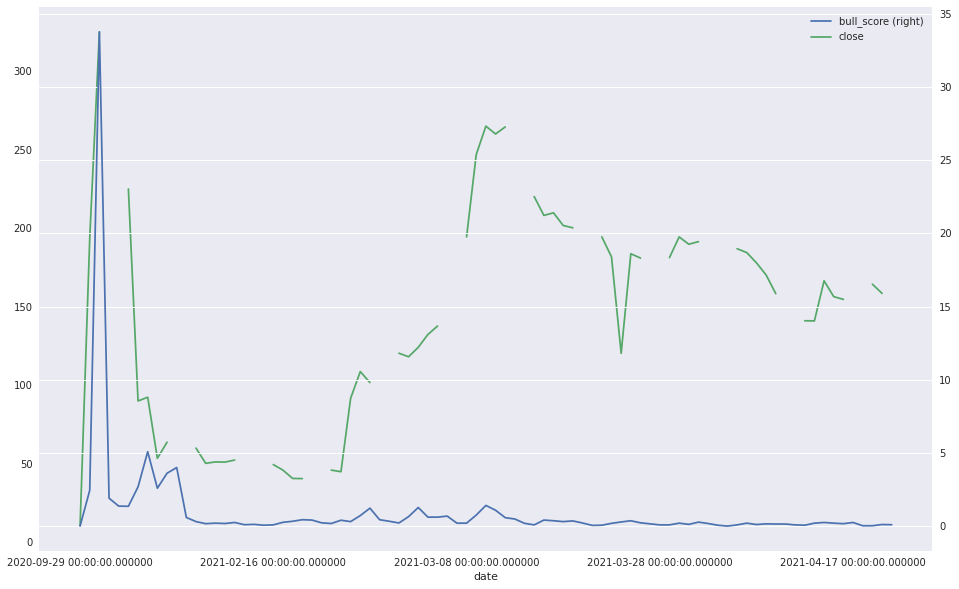

In [ ]:
scores_df_bull = scores_df[['bull_score', 'date', 'close']]
scores_df_bull = scores_df_bull.set_index('date')
scores_df_bull.plot(secondary_y='bull_score', figsize=(16, 10))

We can see that intially, bear and bull scores are better aligned with the stock price. However, as time goes on, both scores seem to be much smaller than they should be. This might be because of the spike that lowered the rest of the normalized scores. 

### Neural Network

Next, we train a neural network model to predict the next day's GME stock price based on the bullish/bearish sentiment scores from the previous 14 days (we are trying to account for lag in this case). 
We decided to use a time series prediction model with LSTM Recurrent Neural Networks. Time series data adds complexity of a sequence dependence among the input variables; a powerful type of neural network designed to handle such sequence is the recurrent neural network. The Long Short-Term Memory network or LSTM network is a type of recurrent neural network. For more information, read here: https://en.wikipedia.org/wiki/Long_short-term_memory

We normalize the data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
scores_df['norm_price']=sc.fit_transform(scores_df['close'].to_numpy().reshape(-1, 1))
scores_df['norm_bull']=sc.fit_transform(scores_df['bull_score'].to_numpy().reshape(-1, 1))
scores_df['norm_bear']=sc.fit_transform(scores_df['bear_score'].to_numpy().reshape(-1, 1))

In [ ]:
import tensorflow as tf
from tensorflow import keras
def remove_first(array):
    new_array=[]
    for x in array:
        new_array.append(x[1:])
    return np.asarray(new_array)

In [ ]:
from sklearn.preprocessing import StandardScaler
# get relevant columns
df=scores_df[['norm_price', 'norm_bull', 'norm_bear']]
df = df.dropna()
df = df.to_numpy()
window=15
gap=1
data=[]
for x in range(len(df)-window): 
    data.append(df[x:x+window])
data=np.asarray(data)
train=data[:-20]
test=data[-20:]
np.random.shuffle(train)
# divide into train and test sets
X_train=[]
y_train=[]
for d in train:
    X_train.append(remove_first(d[:window-gap]))
    y_train.append(d[-1][0])

X_test=[]
y_test=[]
for d in test:
    X_test.append(remove_first(d[:window-gap]))
    y_test.append(d[-1][0])
    
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)
X_test=np.asarray(X_test)
y_test=np.asarray(y_test)

This array has 3 dimensions: 
1.   First is the number of windows
2.   Second is the number of days in each window (15)
3.   Third is the number of features (3).
We then divide the array into a train and test set and shuffle the test set and divide the train and test set into X train and y train, and X test and y test, to map inputs.


In [ ]:
#train lstm model
tf.keras.backend.clear_session()
tf.random.set_seed(2021)
np.random.seed(2021)

mc=tf.keras.callbacks.ModelCheckpoint(filepath='lstm_bullbear_sentiment_1.h5', monitor='val_loss', save_best_only=True)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(48, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    tf.keras.layers.LSTM(48,return_sequences=True),
    tf.keras.layers.LSTM(48),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(12, activation="relu"),
    tf.keras.layers.Dense(1),
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, batch_size=32, validation_data= (X_test, y_test), epochs=100, callbacks=[mc]).history

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.2511 - val_loss: 0.2480
Epoch 2/100
1/1 [==============================] - 0s 69ms/step - loss: 0.2366 - val_loss: 0.2301
Epoch 3/100
1/1 [==============================] - 0s 85ms/step - loss: 0.2207 - val_loss: 0.2097
Epoch 4/100
1/1 [==============================] - 0s 100ms/step - loss: 0.2031 - val_loss: 0.1865
Epoch 5/100
1/1 [==============================] - 0s 72ms/step - loss: 0.1837 - val_loss: 0.1595
Epoch 6/100
1/1 [==============================] - 0s 73ms/step - loss: 0.1622 - val_loss: 0.1292
Epoch 7/100
1/1 [==============================] - 0s 72ms/step - loss: 0.1398 - val_loss: 0.0965
Epoch 8/100
1/1 [==============================] - 0s 76ms/step - loss: 0.1186 - val_loss: 0.0629
Epoch 9/100
1/1 [==============================] - 0s 73ms/step - loss: 0.1020 - val_loss: 0.0329
Epoch 10/100
1/1 [==============================] - 0s 69ms/step - loss: 0.0941 - val_loss: 0.0135
Epoch 11/100
1/1 [==

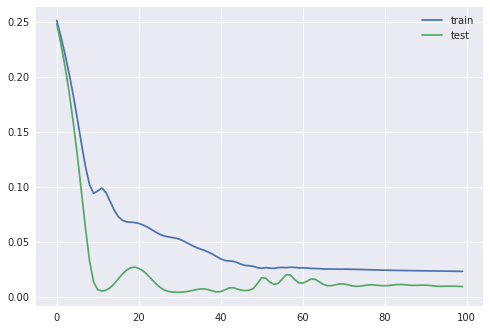

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
# plot history
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()
plt.show()

We make a plot showing the train and test loss during training. We can see that the test loss has been below the training loss. Therefore, the model may be overfitting the training data. This could also be because we are using less than 50 rows of data, so there's not enough for a good neural net. 



<function matplotlib.pyplot.show>

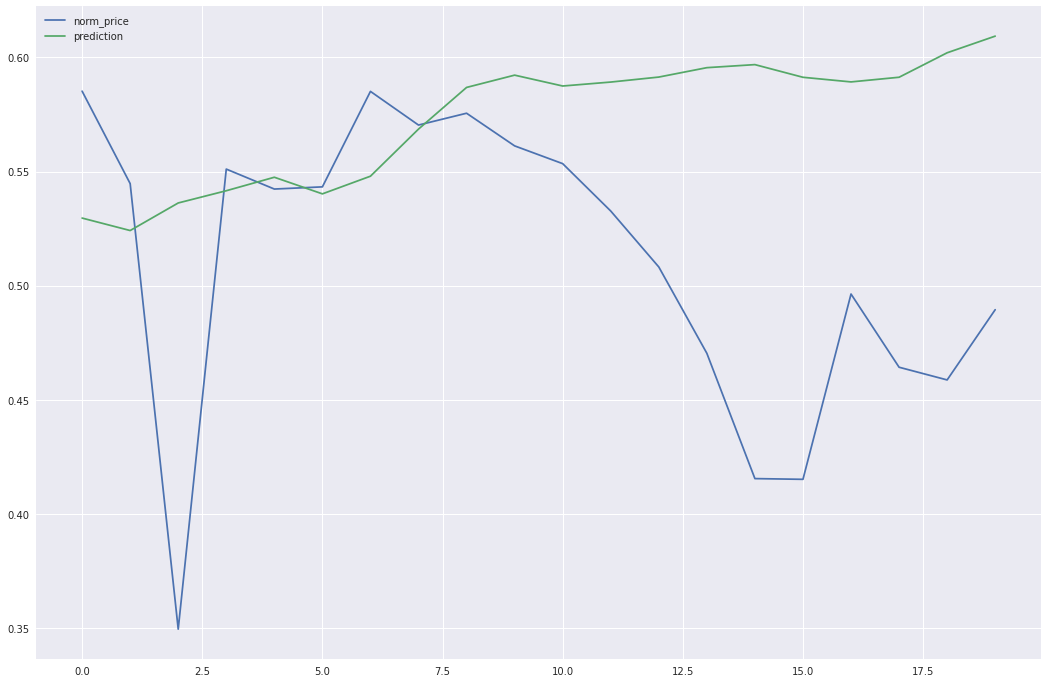

In [ ]:
#predictions
pred=model.predict(X_test)
    
df_predictions=pd.DataFrame(y_test, columns = ['norm_price']) 
df_predictions['prediction']=pred

df_predictions.plot(figsize=(18,12))
plt.show

In [ ]:
print('MEA: ', sum(tf.keras.metrics.mean_absolute_error(y_test, pred).numpy())/len(y_test))

MEA:  0.0707574987784028


We plot the preditions of the model against the true normalized stock price and calculate the mode's test mean absolute error, which is about 0.07. 

# **Description of Challenges/ Obstacles Faced**

* When we were looking at the distinctions among different types of sentiment (positive vs negative vs neutral), we noticed that there was little differences in those areas. Our generated word clouds looks fairly similar among these three. One challenge going forward is being able to have a algorithm that can separate these three sentiments better. 

* We noticed while working with the original dataset is that it is missing a lot of posts from December 2020 - January 2021 and the creator doesn't update old posts' score/comment count. We were able to catch this error when checking specific instances. This could have potentially changed the outcomes of our analysis. To avoid this issue, we pulled the updated data from the Reddit API using the unique identifier of the post.

* When classifying post topics, all three models performed with 50% accuracy over all 7 categories. This might be because the categories are not easily distinguishable (for example, the Discussion flair seems to include posts that could also be classified as News or YOLO, and Gain/Loss could also be considered YOLO).

# **Potential Next Steps/ Future Direction**

* Instead of including only \$GME stock data, we could also include stock prices of other stocks, such as \$AMC, \$NOK, or even S&P500, which all may have been affected by the current situation with \$GME.

* Using text analysis to predict stock prices. Is there a potential trading strategy to better ensure gains?

* Using machine learning/Markov Chains and frequently occurring words/phrases in most popular or least popular posts to generate a popular or unpopular post

* We used post data (`score`, `upvote_ratio`, and `title`) to predict what category/flair it has. For next steps, we could also do something similar to predict upvote ratio.

* There is a significant amount of information contained in comments of posts that gets filtered out by the moderators that could be treated the same way as original posts. We could try analyzing these comments or adding them to our data.